# Climate_Datacsv and Visitor_Data.csv

We separated our Allianz dataset into two different CSV files: Climate_Data and Visitor_Data.



## Focus only on the ski season

We focused only on the ski season (every year from 9 June to 21 September) and removed all other periods. To enable merging with the other dataset, we added a Week column. Finally, we exported the processed dataset as "Climate_season.csv", which contains the cleaned and filtered ski season data with the newly added Week column.

In [1]:
import pandas as pd

# If not already loaded
climate = pd.read_csv("Climate_Data.csv")

# --- Build Date column ---
climate["Date"] = pd.to_datetime(dict(year=climate["Year"],
                                      month=climate["Month"],
                                      day=climate["Day"]))

# --- Define ski season (every year 9 Jun – 21 Sep) ---
def in_ski_season(row):
    # Build two reference dates for that year
    start = pd.Timestamp(year=row["Year"], month=6, day=9)
    end   = pd.Timestamp(year=row["Year"], month=9, day=21)
    return start <= row["Date"] <= end

climate["InSkiSeason"] = climate.apply(in_ski_season, axis=1)

# --- Filter dataset ---
climate_season = climate[climate["InSkiSeason"]].copy()

In [2]:
import pandas as pd

# --- Step 1: Add Week Column (based on ski season mapping) ---
week_map = {
    "06-09": 1, "06-16": 2, "06-23": 3, "06-30": 4,
    "07-07": 5, "07-14": 6, "07-21": 7, "07-28": 8,
    "08-04": 9, "08-11": 10, "08-18": 11, "08-25": 12,
    "09-01": 13, "09-08": 14, "09-15": 15
}

def get_week(date):
    year = date.year
    for d_str, week in week_map.items():
        start = pd.to_datetime(f"{year}-{d_str}")
        end = start + pd.Timedelta(days=6)
        if start <= date <= end:
            return week
    return None

climate_season["Week"] = climate_season["Date"].apply(get_week)

In [3]:
climate_season.to_csv("Climate_season.csv", index=False)


## Handling Missing Values

We identified and displayed the missing values in the dataset, then removed or corrected them step by step.

Rule applied: We only interpolated gaps of up to three consecutive NaN values. If more than three consecutive values were missing, we dropped them instead.

Reasoning: Since this is sequential time-series data, short gaps can be reliably estimated through interpolation without significantly distorting patterns. However, longer gaps may break continuity and introduce bias, so they were excluded to preserve data quality.



In [4]:
# Show only rows with at least one missing value
missing_rows = climate_season[climate_season.isna().any(axis=1)]

missing_rows

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Date,InSkiSeason,Week
571,71075,2011,7,26,1.7,NaN,NaN,2011-07-26,True,7
581,71075,2011,8,5,6.8,4.2,NaN,2011-08-05,True,9
2386,71075,2016,7,14,NaN,-7.0,4.2,2016-07-14,True,6
2387,71075,2016,7,15,NaN,-4.4,NaN,2016-07-15,True,6
2388,71075,2016,7,16,10.3,-3.9,NaN,2016-07-16,True,6
...,...,...,...,...,...,...,...,...,...,...
39113,72161,2023,8,29,11.5,NaN,NaN,2023-08-29,True,12
39484,72161,2024,9,3,NaN,-3.5,2.6,2024-09-03,True,13
39485,72161,2024,9,4,11.6,-0.3,NaN,2024-09-04,True,13
39777,72161,2025,6,23,NaN,2.7,0.0,2025-06-23,True,3


In [5]:
import pandas as pd

rain_col = 'Rainfall amount (millimetres)'

# Convert to numeric, keep NaNs
climate_season[rain_col] = pd.to_numeric(climate_season[rain_col], errors='coerce')

# Rule: only interpolate ≤3 consecutive NaNs, otherwise drop them
MAX_GAP = 3

# Mark NaN runs
mask = climate_season[rain_col].isna()
group = (~mask).cumsum()   # counts groups of NaN and non-NaN
sizes = mask.groupby(group).transform('sum')  # size of each NaN run

# For runs of NaN longer than MAX_GAP → drop
to_drop = mask & (sizes > MAX_GAP)
climate_season = climate_season.loc[~to_drop].copy()

# Interpolate remaining small NaN gaps (≤ MAX_GAP)
climate_season[rain_col] = climate_season[rain_col].interpolate(limit=MAX_GAP)

# If any still left (edge cases at start/end), fill with 0
climate_season[rain_col] = climate_season[rain_col].fillna(0)

print("Remaining NaN values:", climate_season[rain_col].isna().sum())

Remaining NaN values: 0


In [6]:
# Show only rows with at least one missing value
missing_rows = climate_season[climate_season.isna().any(axis=1)]

missing_rows

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Date,InSkiSeason,Week
571,71075,2011,7,26,1.7,NaN,0.9,2011-07-26,True,7
2386,71075,2016,7,14,NaN,-7.0,4.2,2016-07-14,True,6
2387,71075,2016,7,15,NaN,-4.4,2.8,2016-07-15,True,6
7363,71032,2014,8,3,-1.4,NaN,0.0,2014-08-03,True,8
8441,71032,2017,7,16,1.0,NaN,0.0,2017-07-16,True,6
...,...,...,...,...,...,...,...,...,...,...
38008,72161,2020,8,19,NaN,-0.2,5.0,2020-08-19,True,11
39112,72161,2023,8,28,NaN,2.7,9.2,2023-08-28,True,12
39113,72161,2023,8,29,11.5,NaN,5.2,2023-08-29,True,12
39484,72161,2024,9,3,NaN,-3.5,2.6,2024-09-03,True,13


In [7]:
import pandas as pd

# Define column names
station_col = "Bureau of Meteorology station number"
date_col    = "Date"
max_col     = "Maximum temperature (Degree C)"
min_col     = "Minimum temperature (Degree C)"
rain_col    = "Rainfall amount (millimetres)"

# Make sure Date is datetime
climate_season[date_col] = pd.to_datetime(climate_season[date_col])

# Make sure temps are numeric
climate_season[[max_col, min_col]] = climate_season[[max_col, min_col]].apply(
    pd.to_numeric, errors="coerce"
)

MAX_GAP = 3  # rule of thumb: only interpolate ≤3 consecutive days

def interpolate_small_gaps(g, col, max_gap=MAX_GAP):
    g = g.sort_values(date_col).copy()
    s = g[col].copy()
    s.index = g[date_col]  # time index

    isna = s.isna()
    run_id = (isna != isna.shift()).cumsum()
    run_len = isna.groupby(run_id).transform("size")

    # only interpolate *inside* series, not edges
    inside = isna & s.ffill().notna() & s.bfill().notna()
    mask_small_gap = inside & (run_len <= max_gap)

    s_interp = s.interpolate(method="time")
    s_final = s.where(~mask_small_gap, s_interp)

    g[col] = s_final.values
    return g

# Apply per station
climate_season = (climate_season.groupby(station_col, group_keys=False)
                  .apply(lambda g: interpolate_small_gaps(g, max_col, MAX_GAP))
                  .groupby(station_col, group_keys=False)
                  .apply(lambda g: interpolate_small_gaps(g, min_col, MAX_GAP))
                 )

/tmp/ipython-input-1203974835.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: interpolate_small_gaps(g, max_col, MAX_GAP))
/tmp/ipython-input-1203974835.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: interpolate_small_gaps(g, min_col, MAX_GAP))


In [8]:
# Show only rows with at least one missing value
missing_rows = climate_season[climate_season.isna().any(axis=1)]

missing_rows

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Date,InSkiSeason,Week
10680,71032,2023,9,2,NaN,-6.30,0.000000,2023-09-02,True,13
10681,71032,2023,9,3,NaN,NaN,1.733333,2023-09-03,True,13
10682,71032,2023,9,4,NaN,NaN,3.466667,2023-09-04,True,13
10683,71032,2023,9,5,NaN,NaN,5.200000,2023-09-05,True,13
10684,71032,2023,9,6,NaN,NaN,0.600000,2023-09-06,True,13
...,...,...,...,...,...,...,...,...,...,...
31889,85291,2019,6,15,NaN,-0.55,3.600000,2019-06-15,True,1
32335,85291,2020,9,3,NaN,2.90,0.000000,2020-09-03,True,13
32336,85291,2020,9,4,NaN,0.90,0.000000,2020-09-04,True,13
32337,85291,2020,9,5,NaN,-1.10,0.000000,2020-09-05,True,13


In [9]:
max_col = "Maximum temperature (Degree C)"
min_col = "Minimum temperature (Degree C)"

climate_final = climate_season.dropna(subset=[max_col, min_col]).copy()



Now you can see there is no missing value for all data in both climate_season.

In [10]:
# Show only rows with at least one missing value
missing_rows_2 = climate_final[climate_final.isna().any(axis=1)]

missing_rows_2

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Date,InSkiSeason,Week


We dont actually need to deal with Null values in Visitor_Data.csv as there is none. But to make sure we have not miss anything, we just "drop" the Null values directly and save it back to "Visitor_Data.csv":

In [11]:
# If not already loaded
Visitor = pd.read_csv("Visitor_Data.csv")

In [12]:
import pandas as pd

# Load visitor data
Visitor = pd.read_csv("Visitor_Data.csv")

# Drop rows with any null values
Visitor_clean = Visitor.dropna()

# Save back to the same file (overwrite)
Visitor_clean.to_csv("Visitor_Data.csv", index=False)

print("Null values removed. Saved cleaned data back to Visitor_Data.csv")

Null values removed. Saved cleaned data back to Visitor_Data.csv


In [13]:
# If not already loaded
Visitor = pd.read_csv("Visitor_Data.csv")

print(Visitor.isnull().sum())

Year              0
Week              0
Mt. Baw Baw       0
Mt. Stirling      0
Mt. Hotham        0
Falls Creek       0
Mt. Buller        0
Selwyn            0
Thredbo           0
Perisher          0
Charlotte Pass    0
dtype: int64


In [14]:

print(climate_final.isnull().sum())

Bureau of Meteorology station number    0
Year                                    0
Month                                   0
Day                                     0
Maximum temperature (Degree C)          0
Minimum temperature (Degree C)          0
Rainfall amount (millimetres)           0
Date                                    0
InSkiSeason                             0
Week                                    0
dtype: int64


We save the clean data back to "Climate_season_clean.csv". This is the dataset without Null values.


In [15]:
climate_final.to_csv("Climate_season_clean.csv", index=False)  #withoutNull

## Visualizations:

We can plot some graphs and have a look in  "Visitor_Data.csv". We will do the following visualizations to have a good data analysis:

- We shortlist the top spots with by averaging out the visitor days for every location over the whole time period.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
climate_clean = pd.read_csv("Climate_season_clean.csv")
visitor = pd.read_csv("Visitor_Data.csv")

# Print column names
print("🌦 Climate Data Fields:\n", climate_clean.columns.tolist())
print("\n🎿 Visitor Data Fields:\n", visitor.columns.tolist())

# --- Group by Week and average across all years ---
visitor_weekly = visitor.drop(columns=["Year"]).groupby("Week").mean().reset_index()

visitor_weekly = visitor_weekly.round(2)

🌦 Climate Data Fields:
 ['Bureau of Meteorology station number', 'Year', 'Month', 'Day', 'Maximum temperature (Degree C)', 'Minimum temperature (Degree C)', 'Rainfall amount (millimetres)', 'Date', 'InSkiSeason', 'Week']

🎿 Visitor Data Fields:
 ['Year', 'Week', 'Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek', 'Mt. Buller', 'Selwyn', 'Thredbo', 'Perisher', 'Charlotte Pass']


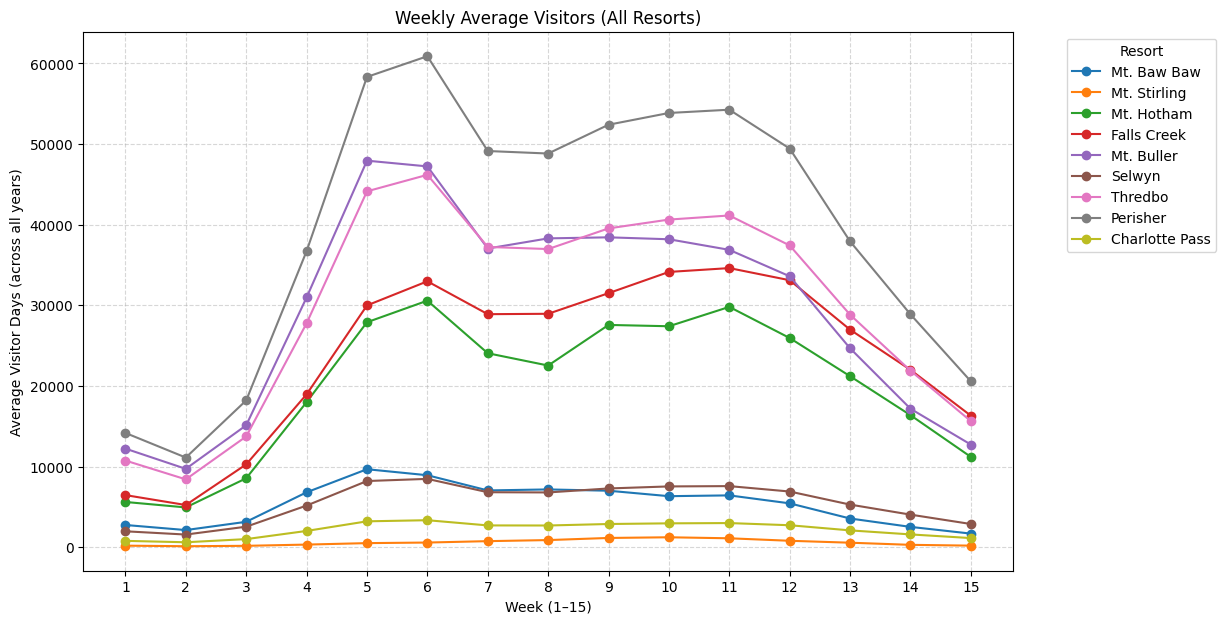

In [20]:
# Plot line chart for each resort (much clearer)
plt.figure(figsize=(12,7))

for col in visitor_weekly.columns[1:]:  # skip 'Week'
    plt.plot(visitor_weekly["Week"], visitor_weekly[col], marker="o", label=col)

plt.title("Weekly Average Visitors (All Resorts)")
plt.xlabel("Week (1–15)")
plt.ylabel("Average Visitor Days (across all years)")
plt.xticks(range(1,16))
plt.legend(title="Resort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## **Most Popular Spots**

Some of the conclusions from the above graph can be drawn as below:

- From the chart we can know for the fact that we have most visitors day from week 5 to 12.

- Resort Perisher is by far the most popular ski resort, the reason could be because it nearly had highest lifted point at 2034m, largest skiable area of around 1250ha with most numbers of lifts ie. 47 which could support maximum skiers.

- Mt Buller and Thredbo even though they have less than half the skiable area than Perisher they closely follow the top destination just because they have more snowmaking area of 70ha+ whereas Perisher only have 53ha. Moreover Thredbo had highest lifted point or 2037m by slight margin.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



## Focus on the Years 2014–2024

We loaded Climate_season_clean.csv (the dataset without null values) and removed all records prior to 2014, since visitor days are not available for those years in the other dataset we plan to merge. The result is saved into "climate_filtered_2014_to_2024.csv"

In [21]:
import pandas as pd

# Load cleaned climate data
climate_clean = pd.read_csv("Climate_season_clean.csv")

# --- Filter 2014–2024 only ---
climate_filtered = climate_clean[
    (climate_clean["Year"] >= 2014) & (climate_clean["Year"] <= 2024)
].copy()


climate_filtered

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Date,InSkiSeason,Week
420,71075,2014,6,9,3.4,-1.8,6.6,2014-06-09,True,1
421,71075,2014,6,10,8.1,-5.0,3.8,2014-06-10,True,1
422,71075,2014,6,11,13.4,-5.1,0.0,2014-06-11,True,1
423,71075,2014,6,12,8.2,-0.6,0.0,2014-06-12,True,1
424,71075,2014,6,13,4.7,2.1,0.0,2014-06-13,True,1
...,...,...,...,...,...,...,...,...,...,...
10813,72161,2024,9,17,7.8,-1.3,0.0,2024-09-17,True,15
10814,72161,2024,9,18,9.4,0.5,0.0,2024-09-18,True,15
10815,72161,2024,9,19,4.0,2.1,0.0,2024-09-19,True,15
10816,72161,2024,9,20,4.1,-0.3,4.4,2024-09-20,True,15


In [22]:
climate_filtered.to_csv("climate_filtered_2014_to_2024.csv", index=False)

## Handling Outliers

We plotted the outliers and treated them by replacing their values with the median instead of removing them.

Reasoning: Outliers may represent rare but valid events (e.g., unusual weather conditions) that should not be discarded. Using the median helps reduce their impact while preserving the integrity of the dataset.

After focusing the data between 2014 and 2024, removing null values, and successfully handling outliers, we saved the cleaned dataset as "Climate_weekly_avg_2014_2024_without_outlier.csv".

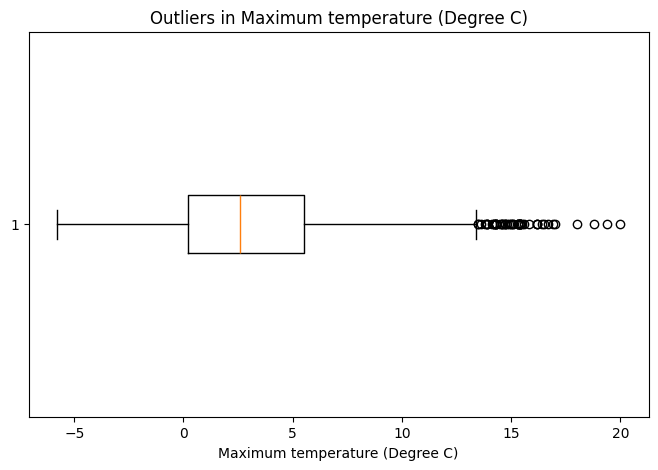

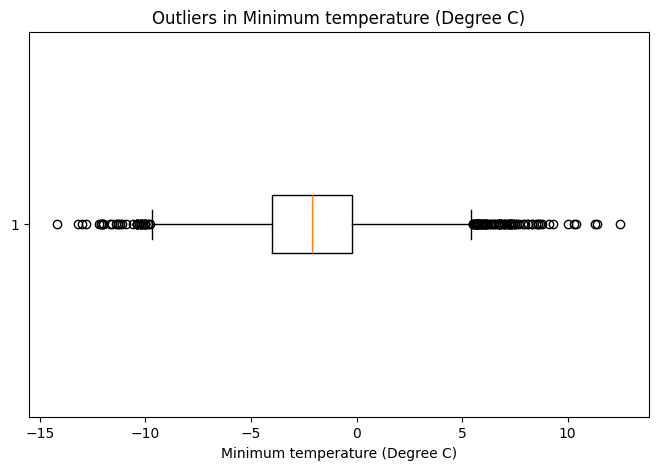

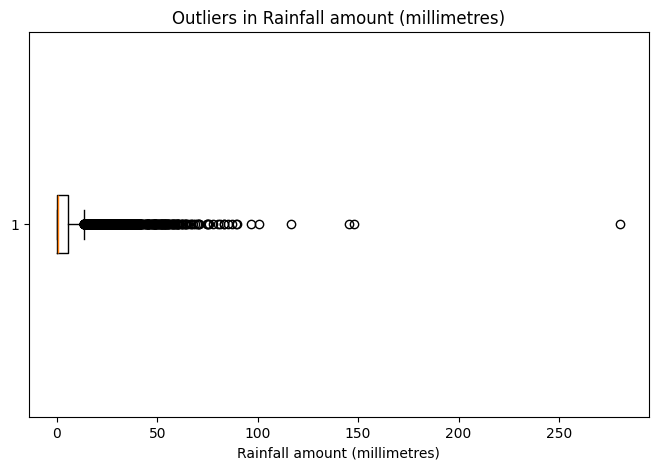

✅ Outliers replaced with column averages
       Maximum temperature (Degree C)  Minimum temperature (Degree C)  \
count                     7672.000000                     7672.000000   
mean                         3.009418                       -2.110864   
std                          3.485330                        2.777587   
min                         -5.800000                       -9.700000   
25%                          0.200000                       -3.900000   
50%                          2.600000                       -2.100000   
75%                          5.400000                       -0.300000   
max                         13.400000                        5.400000   

       Rainfall amount (millimetres)  
count                    7672.000000  
mean                        1.765129  
std                         3.053861  
min                         0.000000  
25%                         0.000000  
50%                         0.400000  
75%                         

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# --- Columns to check for outliers ---
cols = ["Maximum temperature (Degree C)",
        "Minimum temperature (Degree C)",
        "Rainfall amount (millimetres)"]

# --- (1) Plot outliers ---
for col in cols:
    plt.figure(figsize=(8,5))
    plt.boxplot(climate_filtered[col].dropna(), vert=False)
    plt.title(f"Outliers in {col}")
    plt.xlabel(col)
    plt.show()



# --- Function to replace outliers with median ---
def replace_outliers_with_median(df, col):
    q1, q3 = np.percentile(df[col].dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    median_val = df[col].median()
    df.loc[(df[col] < lower) | (df[col] > upper), col] = median_val

# --- (2) Apply function for all columns ---
for col in cols:
    replace_outliers_with_median(climate_filtered, col)

print("✅ Outliers replaced with column averages")
print(climate_filtered[cols].describe())

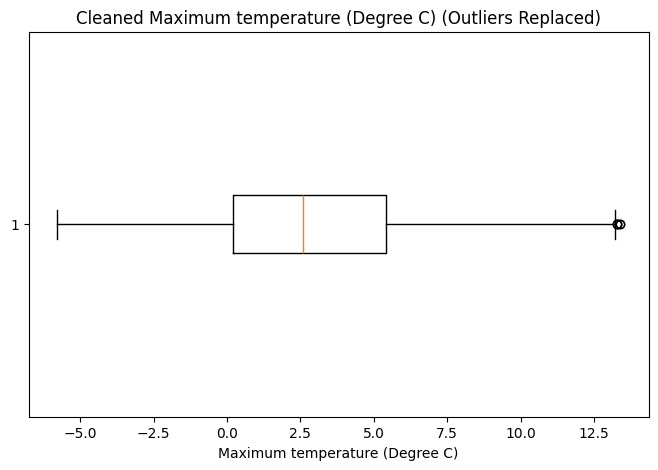

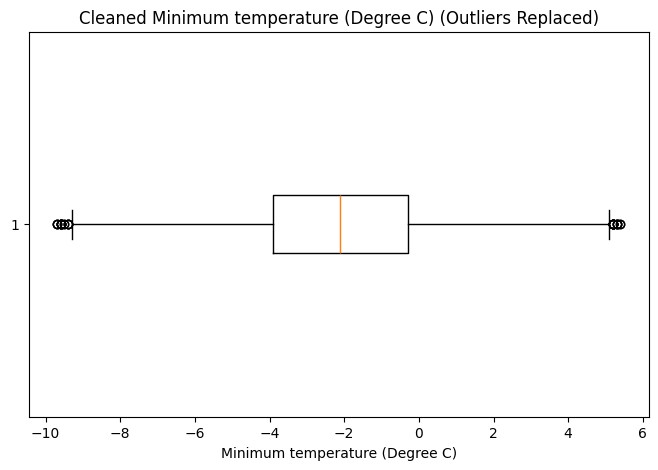

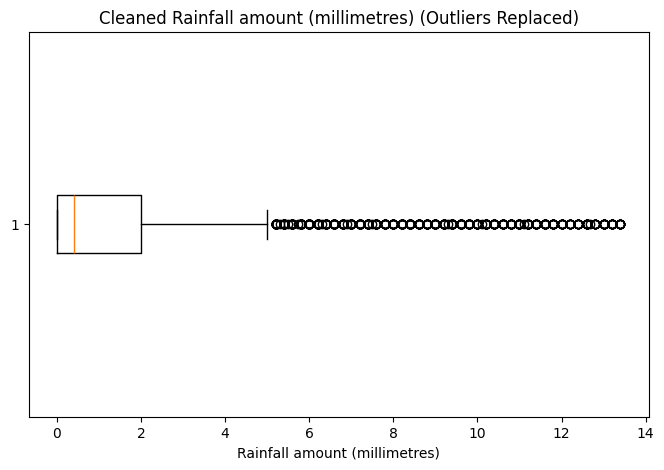

In [24]:
import matplotlib.pyplot as plt

# --- Columns to visualize again ---
cols = ["Maximum temperature (Degree C)",
        "Minimum temperature (Degree C)",
        "Rainfall amount (millimetres)"]

# --- Plot boxplots again after cleaning ---
for col in cols:
    plt.figure(figsize=(8,5))
    plt.boxplot(climate_filtered[col].dropna(), vert=False)
    plt.title(f"Cleaned {col} (Outliers Replaced)")
    plt.xlabel(col)
    plt.show()

In [25]:
climate_filtered.to_csv("Climate_weekly_avg_2014_2024_without_outlier.csv", index=False)

----------- This is the line ------------------------

We start have a perfect dataset without outlier:

## Grouping dataset

We grouped the climate dataset by Year, Week, and Station, then calculated the mean values for maximum temperature, minimum temperature, and rainfall. The results were rounded to two decimals and saved as Climate_weekly_avg_by_year_station.csv for further analysis.

Reasoning: The visitor dataset is organized only by year and week, without daily or monthly records. Therefore, we aggregated the climate data to the same weekly level to ensure consistency when merging both datasets.

In [26]:
# --- Group by Year + Week + Station ---
climate_weekly_avg = climate_filtered.groupby(
    ["Year", "Week", "Bureau of Meteorology station number"], as_index=False
).agg({
    "Maximum temperature (Degree C)": "mean",
    "Minimum temperature (Degree C)": "mean",
    "Rainfall amount (millimetres)": "mean"
})

# Round for clarity
climate_weekly_avg = climate_weekly_avg.round(2)

# Save to CSV
climate_weekly_avg.to_csv("Climate_weekly_avg_by_year_station.csv", index=False)

print("✅ Weekly climate averages by year & station created")
print(climate_weekly_avg.head(20))

✅ Weekly climate averages by year & station created
    Year  Week  Bureau of Meteorology station number  \
0   2014     1                                 71032   
1   2014     1                                 71075   
2   2014     1                                 72161   
3   2014     1                                 83024   
4   2014     1                                 83084   
5   2014     1                                 83085   
6   2014     1                                 85291   
7   2014     2                                 71032   
8   2014     2                                 71075   
9   2014     2                                 72161   
10  2014     2                                 83024   
11  2014     2                                 83084   
12  2014     2                                 83085   
13  2014     2                                 85291   
14  2014     3                                 71032   
15  2014     3                                 71075

## Mapping Resorts to Weather Stations

Since the visitor dataset is organized by ski resorts while the climate dataset is recorded by Bureau of Meteorology (BoM) station numbers, we first needed to link each resort to its corresponding (or nearest) weather station. To achieve this, we created a resort_to_station dictionary, assigning each ski resort to the most relevant BoM station number. For example, Mt. Hotham was mapped to station 83085, while Charlotte Pass was mapped to 71032, which is shared with nearby resorts like Thredbo.

We then inverted this dictionary (station_to_resort) so that each station number could also be mapped back to its associated resort. Finally, using this mapping, we added a new Resort column to the climate dataset, ensuring that both datasets (visitor and climate) shared a common reference point for merging.

In [27]:
Visitor = pd.read_csv("Visitor_Data.csv")

Visitor.columns.tolist()

['Year',
 'Week',
 'Mt. Baw Baw',
 'Mt. Stirling',
 'Mt. Hotham',
 'Falls Creek',
 'Mt. Buller',
 'Selwyn',
 'Thredbo',
 'Perisher',
 'Charlotte Pass']

In [28]:
stations = climate_filtered["Bureau of Meteorology station number"].unique()
print("📍 Unique Bureau of Meteorology station numbers:\n", stations)

📍 Unique Bureau of Meteorology station numbers:
 [71075 71032 83024 83084 83085 85291 72161]


In [29]:
resort_to_station = {
    "Mt. Baw Baw": 85291,
    "Mt. Stirling": 83024,   # proxy, nearest to Mt Buller
    "Mt. Hotham": 83085,
    "Falls Creek": 83084,
    "Mt. Buller": 83024,
    "Selwyn": 72161,
    "Thredbo": 71032,
    "Perisher": 71075,
    "Charlotte Pass": 71032  # shares both Thredbo + Perisher
}


In [30]:
# Invert the resort_to_station dictionary (station → resort)
station_to_resort = {v: k for k, v in resort_to_station.items()}

# Add a new Resort column using the mapping
climate_filtered["Resort"] = climate_filtered["Bureau of Meteorology station number"].map(station_to_resort)


## Reshaping Visitor Data and Merging

The visitor dataset was originally in a wide format, with each resort as a separate column. To make it easier to merge with the climate dataset, we reshaped it into a long format using the melt function. This transformation produced three main columns: Year, Week, and Resort, with the corresponding visitor counts stored under VisitorDays.

Next, we enriched the visitor data by adding the station number to each resort using the resort_to_station mapping created earlier. This step aligned the visitor dataset with the structure of the climate dataset.

Finally, we merged the two datasets (visitor_long and climate_weekly_avg) on Year, Week, and Station number. This inner join ensured that only the records present in both datasets were retained. The resulting dataset combined weekly visitor counts with climate averages for each resort, providing a unified view for further analysis.

In [31]:


# Melt Visitor data to long format
visitor_long = visitor.melt(
    id_vars=["Year", "Week"],
    var_name="Resort",
    value_name="VisitorDays"
)

# Add station number using mapping
visitor_long["Bureau of Meteorology station number"] = visitor_long["Resort"].map(resort_to_station)


In [33]:
# Merge on Year, Week, and Station number
merged_data = pd.merge(
    visitor_long,
    climate_weekly_avg,
    on=["Year", "Week", "Bureau of Meteorology station number"],
    how="inner"
)

print("✅ Merged visitor + climate dataset")
print(merged_data.head(5))

✅ Merged visitor + climate dataset
     Year  Week       Resort  VisitorDays  \
0  2014.0   1.0  Mt. Baw Baw        555.0   
1  2014.0   2.0  Mt. Baw Baw        804.0   
2  2014.0   3.0  Mt. Baw Baw        993.0   
3  2014.0   4.0  Mt. Baw Baw       2976.0   
4  2014.0   5.0  Mt. Baw Baw      11112.0   

   Bureau of Meteorology station number  Maximum temperature (Degree C)  \
0                                 85291                            4.96   
1                                 85291                            5.49   
2                                 85291                            1.04   
3                                 85291                            2.53   
4                                 85291                            0.69   

   Minimum temperature (Degree C)  Rainfall amount (millimetres)  
0                            1.10                           0.63  
1                            0.81                           0.20  
2                           -1.81         

We saved the final merged dataset into a CSV file "merged_data_3:14.csv":

In [34]:
merged_data.to_csv("merged_data_3:14.csv", index=False)

# **Analysis with respect to Weather**

The second part of the analysis revolves around analysis of the data with respect to weather. For this, we have defined thresholds and categorized weather into the following 3 categories:

- Less Cold (Temprature is not too low > 5 degree)
- Mild Cold (Temprature is low)
- Sever Cold (Temprature is ver low < 0 degree)

In [36]:
weather_df = pd.read_csv('merged_data_3:14.csv')

In [37]:
conditions = [
    (weather_df["Maximum temperature (Degree C)"] <= 2),  # Cold
    (weather_df["Maximum temperature (Degree C)"].between(2, 5)),  # Moderate
    (weather_df["Maximum temperature (Degree C)"] > 5)  # Warm
]

# Refine with Min temp within each range
choices = [
    np.where(weather_df["Minimum temperature (Degree C)"] <= -2, "Severe Cold", "Mild Cold"),
    np.where(weather_df["Minimum temperature (Degree C)"] <= 0, "Mild Cold", "Less Cold"),
    "Less Cold"
]

# Apply categories
weather_df["Coldness Level"] = np.select(conditions, choices, default="Uncategorized")


In [38]:
weather_df.head()

,Year,Week,Resort,VisitorDays,Bureau of Meteorology station number,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Coldness Level
0,2014.0,1.0,Mt. Baw Baw,555.0,85291,4.96,1.10,0.63,Less Cold
1,2014.0,2.0,Mt. Baw Baw,804.0,85291,5.49,0.81,0.20,Less Cold
2,2014.0,3.0,Mt. Baw Baw,993.0,85291,1.04,-1.81,2.21,Mild Cold
3,2014.0,4.0,Mt. Baw Baw,2976.0,85291,2.53,-0.96,1.11,Mild Cold
4,2014.0,5.0,Mt. Baw Baw,11112.0,85291,0.69,-2.26,3.40,Severe Cold


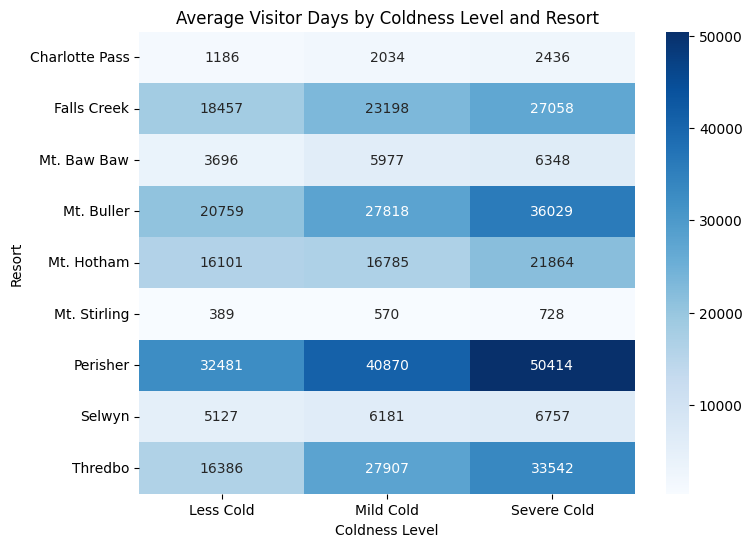

In [39]:
import seaborn as sns
heatmap_data = (
    weather_df.groupby(["Resort", "Coldness Level"])["VisitorDays"]
      .mean()
      .reset_index()
)

# Pivot for heatmap (Resort as rows, Coldness Level as columns)
heatmap_pivot = heatmap_data.pivot(index="Resort", columns="Coldness Level", values="VisitorDays")

plt.figure(figsize=(8, 6))

ax = sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt=".0f",   # ✅ comma formatting
    cmap="Blues"
)

plt.title("Average Visitor Days by Coldness Level and Resort")
plt.xlabel("Coldness Level")
plt.ylabel("Resort")

plt.show()

From the above heatmap, we are able to visualize that the visitor days increase when the wheather tends to be towards mild or sever cold. This means more people head towards these points as the temprature falls

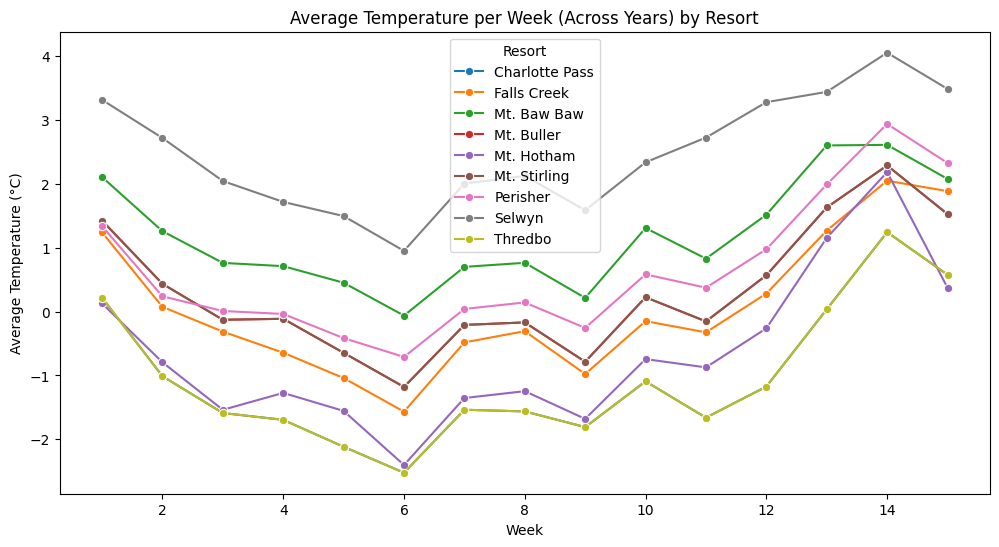

In [40]:
weather_df["Average Temp"] = (weather_df["Maximum temperature (Degree C)"] + weather_df["Minimum temperature (Degree C)"]) / 2

# -------------------
# 2. Average over all years for each Week and Resort
# -------------------
avg_temp_weekly = (
    weather_df.groupby(["Resort", "Week"])["Average Temp"]
      .mean()
      .reset_index()
)

# -------------------
# 3. Plot Average Temp per Week for each Resort
# -------------------
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_temp_weekly, x="Week", y="Average Temp", hue="Resort", marker="o")
plt.title("Average Temperature per Week (Across Years) by Resort")
plt.ylabel("Average Temperature (°C)")
plt.xlabel("Week")
plt.legend(title="Resort")
plt.show()

This visualization helps to find the optimal season for skiing. As from the visualization, it is evident that week 4 to week 6 record low tempratures and keeping in view the above visualizations, these are the times where the skiing season peaks.

## **Analysis with respect to Accomodation Cost**

In this section we have done analysis with respect to average accomodation cost of different locations. We have gathered data from web and estimated the average cost and have analysed that with respect to different times like in week or at weekends


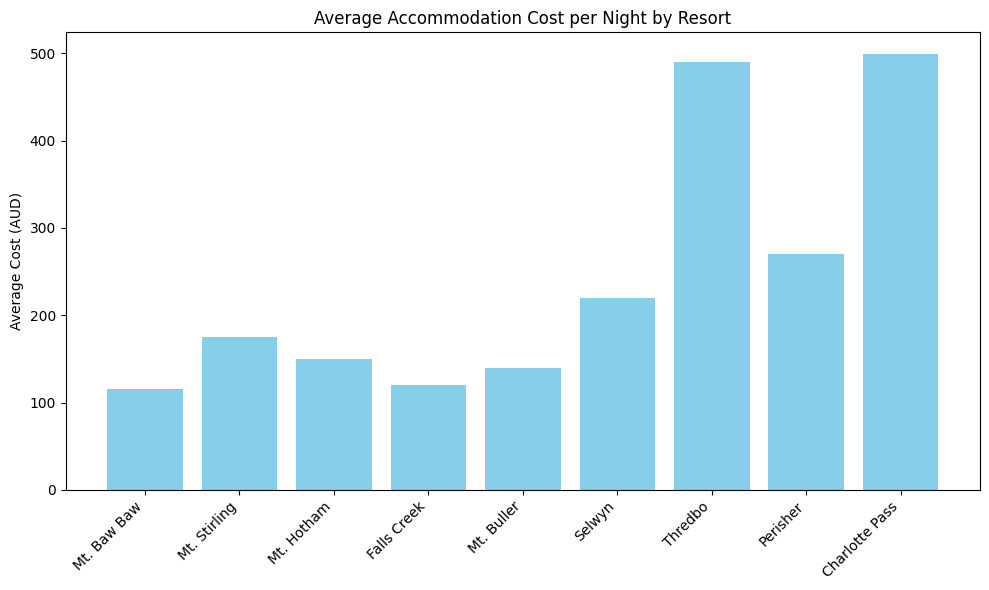

In [42]:
price_df = pd.read_csv("Price Data.csv")

# Bar chart of average costs
plt.figure(figsize=(10,6))
plt.bar(price_df["Resort"], price_df["Average Cost (AUD)"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Cost (AUD)")
plt.title("Average Accommodation Cost per Night by Resort")
plt.tight_layout()
plt.show()

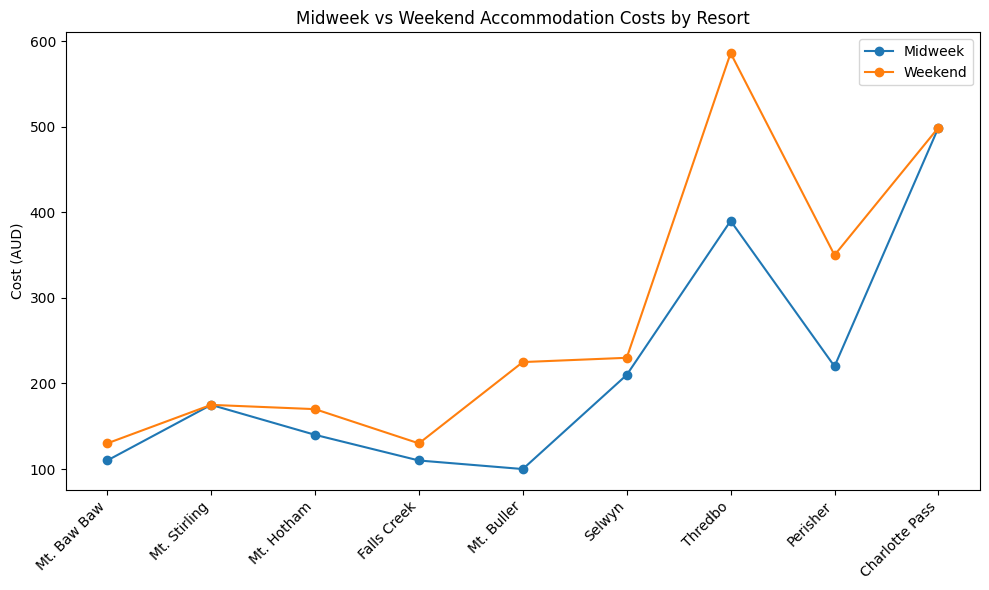

In [43]:
plt.figure(figsize=(10,6))
plt.plot(price_df["Resort"], price_df["Midweek"], marker="o", label="Midweek")
plt.plot(price_df["Resort"], price_df["Weekend"], marker="o", label="Weekend")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Cost (AUD)")
plt.title("Midweek vs Weekend Accommodation Costs by Resort")
plt.legend()
plt.tight_layout()
plt.show()


The analysis shows that some of the popular locations have high accomodation prices. This can be due to better facilities available. Moreover, the general trend shows that the prices during the weeks are less as compared to weekends

# **Analysis with respect to features**

In this section, we take dataset published on web regarding features of different locations. This helps us to check what is impact of features of different locations on the visitor days.

In [52]:
features_df = pd.read_csv("features.csv")
features_df_shortlisted = features_df.drop(['Bureau of Meteorology station number', 'Maximum temperature (Degree C)', 'Minimum temperature (Degree C)','Rainfall amount (millimetres)', 'VisitorDays','Year', 'Week'], axis=1)
features_df_shortlisted = features_df_shortlisted.drop_duplicates(subset='Resort')
features_df_shortlisted

,Resort,Highest Lifted Point,Lowest Lifted Point,Skiable Area,Snow Making Area,Lifts
0,Mt. Baw Baw,1562m,1407m,30ha,10ha,7
165,Mt. Hotham,1945m,1450m,320ha,25ha,13
330,Falls Creek,1780m,1500m,450ha,100ha,15
495,Mt. Buller,1805m,1375m,300ha,70ha+,22
660,Selwyn,1614m,1492m,45ha,36ha,11
825,Thredbo,2037m,1365m,480ha,70ha,14
990,Perisher,2034m,1605m,1245ha,53.4ha,47
1155,Charlotte Pass,1955m,1760m,50ha,10ha,6


These are the features of all the resorts. Now we would perform an analysis with respect to these features

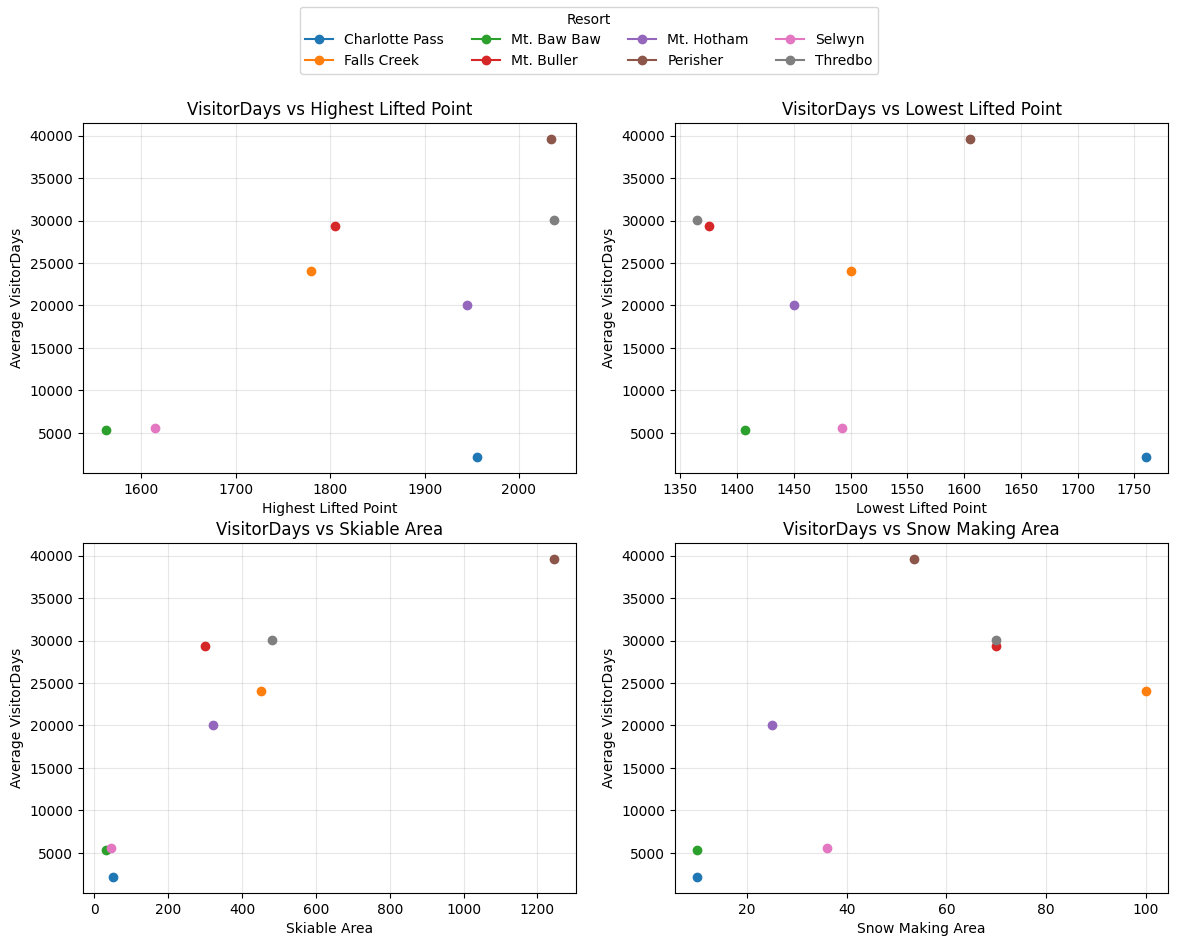

In [53]:
import matplotlib.pyplot as plt

def extract_numeric(series):
    return series.astype(str).str.extract(r"(\d+\.?\d*)").astype(float)

for col in ["Highest Lifted Point", "Skiable Area", "Lowest Lifted Point","Snow Making Area"]:
    features_df[col] = extract_numeric(features_df[col])

# 📌 Aggregate by resort (average VisitorDays, features remain constant per resort)
resort_summary = features_df.groupby("Resort").agg({
    "VisitorDays": "mean",
    "Highest Lifted Point": "max",
    "Lowest Lifted Point": "min",
    "Skiable Area": "max",
    "Snow Making Area": "max"
}).reset_index()


# 📌 Features to plot
features = ["Highest Lifted Point", "Lowest Lifted Point", "Skiable Area", "Snow Making Area"]

# 📌 Create subplots for each feature
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    for resort in resort_summary["Resort"].unique():
        subset = resort_summary[resort_summary["Resort"] == resort]
        axes[i].plot(subset[feature], subset["VisitorDays"], marker="o", label=resort)

    axes[i].set_title(f"VisitorDays vs {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Average VisitorDays")
    axes[i].grid(True, alpha=0.3)

# 📌 Add one legend for all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, title="Resort")

#plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.suptitle("Resorts: VisitorDays vs Features", fontsize=16)
plt.show()


Now we do some analysis based on ease of access to the points. The ease of access is defined on different parameters like road conditions, requirement of vehicle types, transport restrictions etc.

We have catgorized the ease of access into following categories:

- Easy
- Moderate
- Difficult

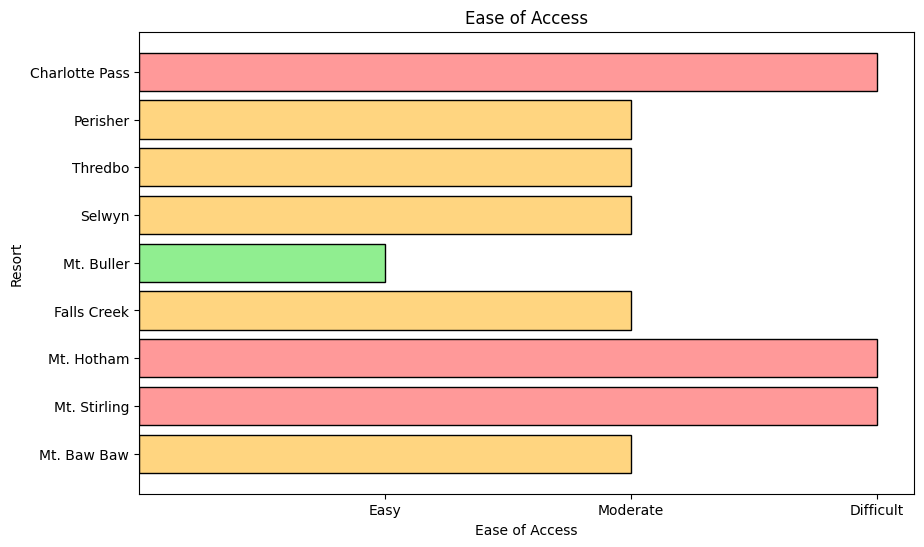

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load CSV
ease_df = pd.read_csv("ease.csv")

# Map ease of access to numeric values
ease_mapping = {"Easy": 1, "Moderate": 2, "Difficult": 3}
ease_df["Ease_Num"] = ease_df["Ease of Access"].map(ease_mapping)

# Set colors for categories

color_mapping = {
    "Easy": "#90ee90",      # light green
    "Moderate": "#ffd580",  # light orange / pastel
    "Difficult": "#ff9999"  # light red / pastel
}

ease_df["Color"] = ease_df["Ease of Access"].map(color_mapping)
ease_df["Color"] = ease_df["Ease of Access"].map(color_mapping)

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(ease_df["Resort"], ease_df["Ease_Num"], color=ease_df["Color"], edgecolor='black')
plt.xticks([1,2,3], ["Easy", "Moderate", "Difficult"])
plt.xlabel("Ease of Access")
plt.ylabel("Resort")
plt.title("Ease of Access")
plt.show()

 # Model training

Now we use the perfect dataset "merged_data_3:14.csv" to train the model.
We firstly print out the resort of rows to see if we have the balance data acrross 9  unique locations

Before training, we examined the distribution of rows across resorts to check for balance. The dataset contains 1435 rows covering 9 unique resorts. The counts are relatively even across locations, with most resorts contributing between 160–165 rows each (≈11–12% of the data). Only Mt. Hotham is slightly underrepresented with 129 rows (≈9%). Overall, the dataset is well balanced, ensuring that no single resort dominates the model training process.

Total rows: 1435 | Unique resorts: 9
                count  percent
Resort                        
Mt. Baw Baw       165     11.5
Mt. Stirling      165     11.5
Mt. Buller        165     11.5
Perisher          165     11.5
Falls Creek       163    11.36
Selwyn            163    11.36
Thredbo           160    11.15
Charlotte Pass    160    11.15
Mt. Hotham        129     8.99


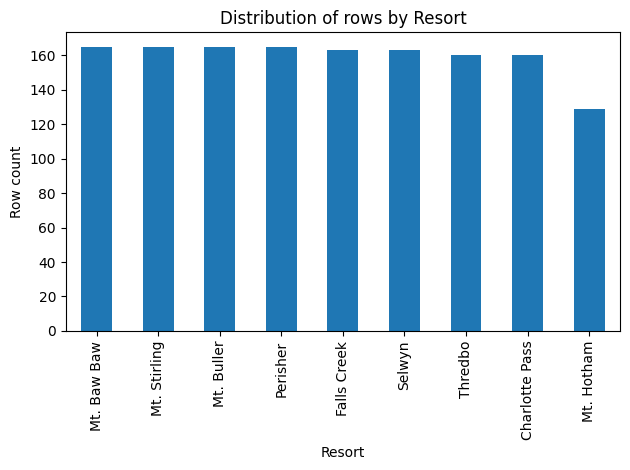

In [ ]:

import matplotlib.pyplot as plt

# Load
df = pd.read_csv("merged_data_3:14.csv")

# Clean minor whitespace just in case
resort = df["Resort"].astype("string").str.strip()

# Counts and percentages
dist = resort.value_counts(dropna=False).rename_axis("Resort").to_frame("count")
dist["percent"] = (dist["count"] / len(df) * 100).round(2)

print(f"Total rows: {len(df)} | Unique resorts: {dist.shape[0]}")
print(dist.sort_values("count", ascending=False))

# (Optional) bar chart of counts
plt.figure()
dist.sort_values("count", ascending=False)["count"].plot(kind="bar")
plt.title("Distribution of rows by Resort")
plt.xlabel("Resort")
plt.ylabel("Row count")
plt.tight_layout()
plt.show()

## Core training
We train a leak-free LSTM (PyTorch) to forecast weekly VisitorDays, using 2014–2019 and 2021–2023 for training (2020 excluded) and 2024 for testing. Inputs are max/min temperature, rainfall, week-of-year (sin/cos), and one-hot resort; a 6-week sliding window feeds a 2-layer LSTM (hidden size 64, dropout 0.3) with Adam/MSE and early stopping. All scalers are fit only on the training years, and 2024 is predicted roll-forward (each week uses only past information; no 2024 ground truth is used). We report realistic RMSE and R² on 2024, then present a weekly comparison table (one row per week, summed across resorts) and a bar chart of predicted vs actual weekly totals.



Overall, the LSTM provides a reasonable and realistic forecast for 2024, with a test R² of 0.68. The predictions are not exact in magnitude, especially in early weeks, but the model succeeds in capturing the timing of the seasonal peak and the rise-and-fall structure of visitation. For practical decision-making (e.g., recommending the best week for skiing in 2026), this performance is acceptable since the model correctly highlights the critical peak window of Weeks 5–7.

Early stopping at epoch 29

Leak-free LSTM — Test RMSE: 10669.40, R²: 0.680

=== Weekly Comparison Table (2024, Leak-free LSTM) ===
 Week  GroundTruth_VisitorDays  Predicted_VisitorDays
    1                  28947.0          112661.745972
    2                  37239.0          150322.345337
    3                  49568.0          198594.750488
    4                 111777.0          246277.649414
    5                 247680.0          277922.366699
    6                 267269.0          302934.035156
    7                 254353.0          285570.837402
    8                 240920.0          267279.483398
    9                 257842.0          246803.531982
   10                 231476.0          212373.562256
   11                 209851.0          180949.120911
   12                 187307.0          149807.378296
   13                 103569.0          124884.834900
   14                  35982.0          101629.090088
   15                  23428.0           91489.124405


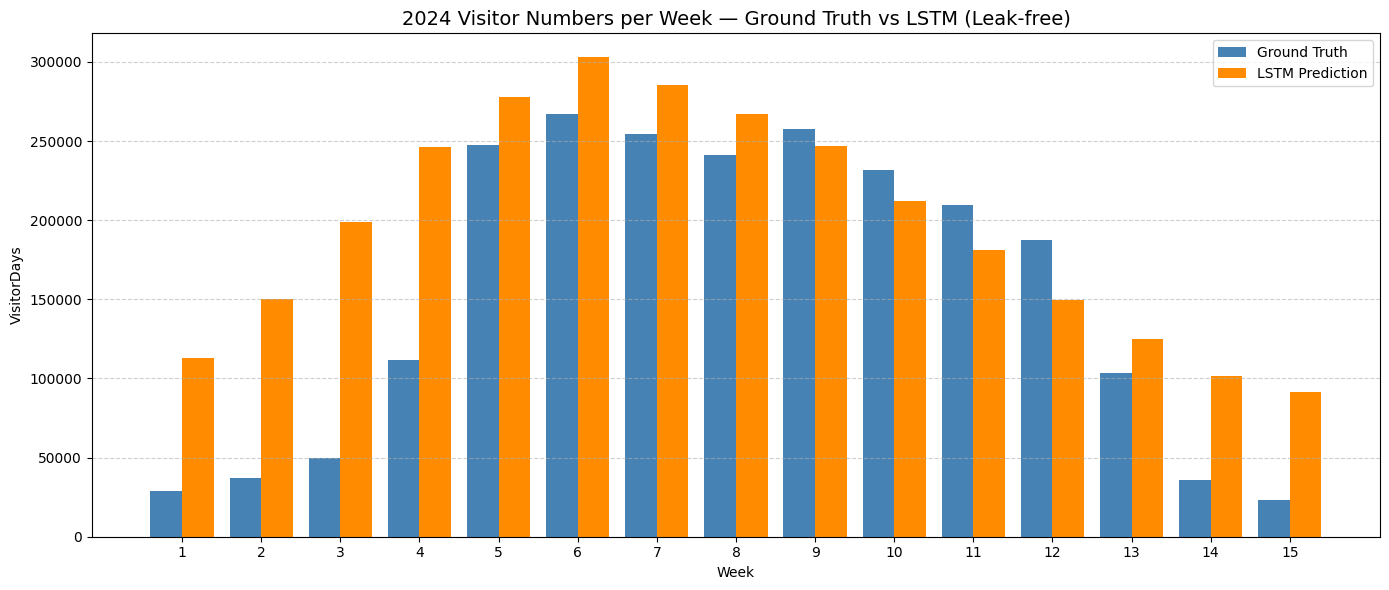

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# -----------------------------
# Load & tidy
# -----------------------------
df = pd.read_csv("merged_data_3:14.csv")

# Rename for convenience
col_map = {
    "Maximum temperature (Degree C)": "tmax",
    "Minimum temperature (Degree C)": "tmin",
    "Rainfall amount (millimetres)": "rain_mm",
}
df = df.rename(columns=col_map)

for c in ["Year","Week","VisitorDays","tmax","tmin","rain_mm"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep resort string for safe lag handling
df = df.ffill().sort_values(["Resort","Year","Week"]).reset_index(drop=True)

# -----------------------------
# Engineered features
# -----------------------------
df["week_sin"] = np.sin(2*np.pi*df["Week"]/52.0)
df["week_cos"] = np.cos(2*np.pi*df["Week"]/52.0)

# Preserve resort label before one-hot encoding
df["ResortLabel"] = df["Resort"]

# One-hot resorts
df = pd.get_dummies(df, columns=["Resort"], drop_first=False)

# -----------------------------
# Train/Test split
# -----------------------------
# Train/Test split
train_mask = (df["Year"] <= 2023) & (df["Year"] != 2020)   # exclude 2020 only
test_mask  = (df["Year"] == 2024)

features = ["tmax","tmin","rain_mm","week_sin","week_cos"] + \
           [c for c in df.columns if c.startswith("Resort_")]
target = "VisitorDays"

X_train = df.loc[train_mask, features].values
y_train = df.loc[train_mask, target].values
X_test  = df.loc[test_mask,  features].values
y_test  = df.loc[test_mask,  target].values

# -----------------------------
# Scaling (fit only on TRAIN)
# -----------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_s  = scaler_y.transform(y_test.reshape(-1,1))

# -----------------------------
# Sequence dataset
# -----------------------------
SEQ_LEN = 6

class SeqDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X, self.y, self.seq_len = X, y, seq_len
    def __len__(self):
        return len(self.X) - self.seq_len
    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx+self.seq_len], dtype=torch.float32),
            torch.tensor(self.y[idx+self.seq_len], dtype=torch.float32)
        )

train_ds = SeqDataset(X_train_s, y_train_s, SEQ_LEN)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)

# -----------------------------
# LSTM Model
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

input_dim = X_train_s.shape[1]
model = LSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=2, dropout=0.3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# -----------------------------
# Training with Early Stopping
# -----------------------------
EPOCHS = 200
patience = 15
best_loss = float("inf")
patience_counter = 0
best_state = None

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= max(1, len(train_loader))

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        best_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# -----------------------------
# Roll-forward evaluation (no leakage)
# -----------------------------
model.eval()
pred_rows = []

# Iterate over resorts separately
for res in sorted(df.loc[test_mask,"ResortLabel"].unique()):
    train_res = df.loc[train_mask & (df["ResortLabel"]==res)].sort_values(["Year","Week"])
    test_res  = df.loc[test_mask  & (df["ResortLabel"]==res)].sort_values(["Year","Week"])
    if len(test_res)==0: continue

    # seed with last SEQ_LEN training rows for this resort
    seed_block = train_res[features].values[-SEQ_LEN:]
    if seed_block.shape[0] < SEQ_LEN:
        need = SEQ_LEN - seed_block.shape[0]
        seed_block = np.vstack([np.repeat(seed_block[:1], need, axis=0), seed_block])
    buf = scaler_X.transform(seed_block).tolist()

    for _, row in test_res.iterrows():
        x_row = row[features].to_numpy(copy=True)
        x_row_s = scaler_X.transform(x_row.reshape(1,-1))[0]

        seq = np.vstack(buf[1:] + [x_row_s]).astype(np.float32)
        with torch.no_grad():
            pred_s = model(torch.tensor(seq).unsqueeze(0)).cpu().numpy()
        pred = scaler_y.inverse_transform(pred_s.reshape(-1,1)).flatten()[0]

        pred_rows.append({
            "Resort": res,
            "Year": int(row["Year"]),
            "Week": int(row["Week"]),
            "GT_VisitorDays": float(row["VisitorDays"]),
            "Pred_VisitorDays": float(pred)
        })
        buf = buf[1:] + [x_row_s]

pred_df = pd.DataFrame(pred_rows).sort_values(["Week","Resort"]).reset_index(drop=True)

# Metrics across all 2024 resort-weeks
rmse = np.sqrt(mean_squared_error(pred_df["GT_VisitorDays"], pred_df["Pred_VisitorDays"]))
r2   = r2_score(pred_df["GT_VisitorDays"], pred_df["Pred_VisitorDays"])
print(f"\nLeak-free LSTM — Test RMSE: {rmse:.2f}, R²: {r2:.3f}")

# -----------------------------
# Weekly comparison (sum across resorts)
# -----------------------------
weekly_sum = (pred_df.groupby("Week", as_index=False)[["GT_VisitorDays","Pred_VisitorDays"]]
              .sum()
              .rename(columns={"GT_VisitorDays":"GroundTruth_VisitorDays",
                               "Pred_VisitorDays":"Predicted_VisitorDays"}))

print("\n=== Weekly Comparison Table (2024, Leak-free LSTM) ===")
print(weekly_sum.to_string(index=False))

# -----------------------------
# Plot
# -----------------------------
x = np.arange(len(weekly_sum))
width = 0.4
plt.figure(figsize=(14,6))
plt.bar(x - width/2, weekly_sum["GroundTruth_VisitorDays"], width, label="Ground Truth", color="steelblue")
plt.bar(x + width/2, weekly_sum["Predicted_VisitorDays"], width, label="LSTM Prediction", color="darkorange")
plt.title("2024 Visitor Numbers per Week — Ground Truth vs LSTM (Leak-free)", fontsize=14)
plt.xlabel("Week"); plt.ylabel("VisitorDays")
plt.xticks(x, weekly_sum["Week"].values)
plt.legend(); plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

### This is our final table:


Both the ground truth and the LSTM pick the same peak: Perisher in Week 6.
The model’s predicted visitors (≈ 67,651) are very close to the actual (64,682), an error of about +2,969 (≈ 4.6%).
This agreement on both timing and location validates the model for making forward recommendations (e.g., targeting mid–late July at Perisher).

In [ ]:
# ============================
# Peak comparison: Ground Truth vs Prediction
# ============================

# Peak week & resort in 2024 Ground Truth
peak_gt = (
    pred_df.loc[pred_df.groupby(["Week","Resort"])["GT_VisitorDays"].idxmax()]
             .sort_values("GT_VisitorDays", ascending=False)
             .head(1)
)

# Peak week & resort in 2024 Prediction
peak_pred = (
    pred_df.loc[pred_df.groupby(["Week","Resort"])["Pred_VisitorDays"].idxmax()]
             .sort_values("Pred_VisitorDays", ascending=False)
             .head(1)
)

# Combine into one comparison table
peak_compare = pd.concat([
    peak_gt.assign(Source="Ground Truth"),
    peak_pred.assign(Source="Prediction (LSTM)")
], ignore_index=True)

print("\n=== Peak Week & Resort (2024) Comparison ===")
print(peak_compare[["Source","Year","Week","Resort","GT_VisitorDays","Pred_VisitorDays"]].to_string(index=False))


=== Peak Week & Resort (2024) Comparison ===
           Source  Year  Week   Resort  GT_VisitorDays  Pred_VisitorDays
     Ground Truth  2024     6 Perisher         64682.0      67651.328125
Prediction (LSTM)  2024     6 Perisher         64682.0      67651.328125


Best Week & Resort (2014–2024) with 2024 Validation:

This summary shows a stable, repeatable pattern: across 2014–2024, the peak almost always occurs at Perisher, typically in Weeks 5–6 (late July). The only clear anomalies are 2015/2019 (Week 11 rebounds) and 2020 (COVID-affected, Mt. Buller). For 2024, the LSTM exactly matches the ground truth peak (Perisher, Week 6) with a close magnitude. Together, this validates our model and supports a 2026 recommendation: Perisher in Weeks 5–6 as the most reliable window for peak conditions and activity.

In [ ]:
# =========================================================
# Best Week & Resort: Prediction (2024) vs Historical GT
# =========================================================

# --- Best week & resort in 2024 (from predictions) ---
best_2024 = (
    pred_df.loc[pred_df.groupby(["Week"])["Pred_VisitorDays"].idxmax()]
    .loc[pred_df["Pred_VisitorDays"].idxmax()]
)

# --- Best week & resort in each historical year (GT) ---
best_per_year = (
    df.groupby(["Year","Week","ResortLabel"])["VisitorDays"]
      .sum()
      .reset_index()
)

best_each_year = (
    best_per_year.loc[best_per_year.groupby("Year")["VisitorDays"].idxmax()]
    .sort_values("Year")
    .reset_index(drop=True)
)

# --- Combine into one table ---
compare_table = best_each_year.copy()
compare_table["Source"] = "Ground Truth"

# add 2024 prediction row
compare_table = pd.concat([
    compare_table,
    pd.DataFrame([{
        "Year": 2024,
        "Week": int(best_2024["Week"]),
        "ResortLabel": best_2024["Resort"],
        "VisitorDays": best_2024["Pred_VisitorDays"],
        "Source": "Prediction (LSTM)"
    }])
], ignore_index=True)

print("\n=== Best Week & Resort per Year (GT vs 2024 Prediction) ===")
print(compare_table.to_string(index=False))


=== Best Week & Resort per Year (GT vs 2024 Prediction) ===
  Year  Week ResortLabel  VisitorDays            Source
2014.0   6.0    Perisher 76855.000000      Ground Truth
2015.0  11.0    Perisher 68527.000000      Ground Truth
2016.0   5.0    Perisher 64386.000000      Ground Truth
2017.0   6.0    Perisher 76620.000000      Ground Truth
2018.0   6.0    Perisher 93226.000000      Ground Truth
2019.0  11.0    Perisher 77783.000000      Ground Truth
2020.0   6.0  Mt. Buller 15619.000000      Ground Truth
2021.0   5.0    Perisher 55654.000000      Ground Truth
2022.0   5.0    Perisher 77499.000000      Ground Truth
2023.0   5.0    Perisher 66365.000000      Ground Truth
2024.0   6.0    Perisher 64682.000000      Ground Truth
2024.0   6.0    Perisher 67651.328125 Prediction (LSTM)


## Final Prediction of the pattern of the best location and best weeks in 2026


Early stopping at epoch 93

Leak-free LSTM (2020 excluded) — 2024 Test RMSE: 10509.17, R²: 0.690

=== Weekly Comparison Table (2024, Leak-free LSTM) ===
 Week  GT_VisitorDays  Pred_VisitorDays
    1         28947.0      71478.431763
    2         37239.0     101579.339600
    3         49568.0     180680.571289
    4        111777.0     244010.331787
    5        247680.0     229323.242188
    6        267269.0     181117.712036
    7        254353.0     195343.013672
    8        240920.0     203087.821045
    9        257842.0     213927.016602
   10        231476.0     178294.330322
   11        209851.0     143654.437866
   12        187307.0     109905.321045
   13        103569.0      77740.132324
   14         35982.0      61859.706665
   15         23428.0      59919.391357


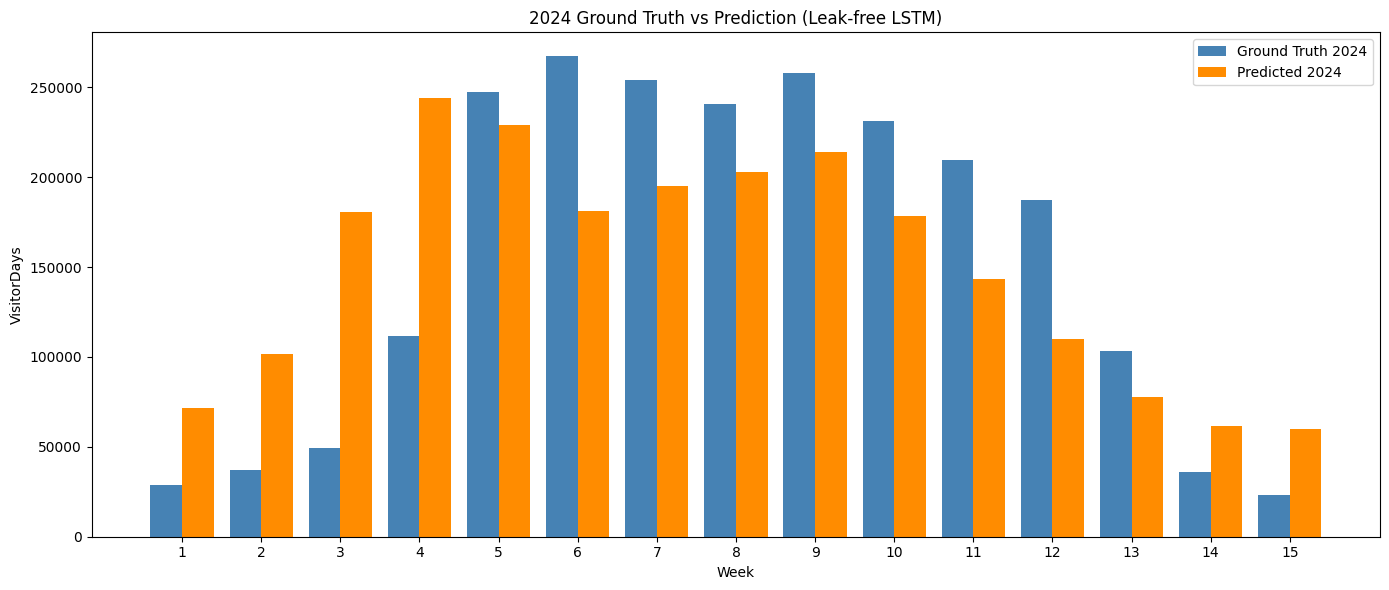


=== Top 4 Locations (2026 Forecast) ===
     Resort    Total_Pred
   Perisher 581282.311523
    Thredbo 452657.155273
 Mt. Buller 375475.226562
Falls Creek 304658.531738

=== Top 4 Weeks (2026 Forecast, across resorts) ===
 Week    Total_Pred
    4 246826.985840
    5 226345.001465
    9 210551.287842
    8 207868.968262


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# ==========================================================
# 1. Load dataset & generate synthetic 2026
# ==========================================================
df = pd.read_csv("merged_data_3_14.csv")

# Rename for convenience
col_map = {
    "Maximum temperature (Degree C)": "tmax",
    "Minimum temperature (Degree C)": "tmin",
    "Rainfall amount (millimetres)": "rain_mm",
}
df = df.rename(columns=col_map)
for c in ["Year","Week","VisitorDays","tmax","tmin","rain_mm"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Synthetic 2026 (based on 2024 + noise)
template_2024 = df[df["Year"] == 2024].copy()
synthetic_2026 = template_2024.copy()
synthetic_2026["Year"] = 2026
rng = np.random.default_rng(42)
for col in ["tmax", "tmin", "rain_mm"]:
    noise = rng.normal(loc=0, scale=0.5, size=len(synthetic_2026))
    synthetic_2026[col] = synthetic_2026[col] + noise
synthetic_2026["VisitorDays"] = np.nan
df = pd.concat([df, synthetic_2026], ignore_index=True)

# Tidy
df = df.ffill().sort_values(["Resort","Year","Week"]).reset_index(drop=True)
df["week_sin"] = np.sin(2*np.pi*df["Week"]/52.0)
df["week_cos"] = np.cos(2*np.pi*df["Week"]/52.0)
df["ResortLabel"] = df["Resort"]
df = pd.get_dummies(df, columns=["Resort"], drop_first=False)

# ==========================================================
# 2. Train/Test split
# ==========================================================
train_mask = (df["Year"] <= 2023) & (df["Year"] != 2020)
test_mask  = (df["Year"] == 2024)
pred_mask  = (df["Year"] == 2026)

features = ["tmax","tmin","rain_mm","week_sin","week_cos"] + \
           [c for c in df.columns if c.startswith("Resort_")]
target = "VisitorDays"

X_train = df.loc[train_mask, features].values
y_train = df.loc[train_mask, target].values
X_test  = df.loc[test_mask,  features].values
y_test  = df.loc[test_mask,  target].values
X_pred  = df.loc[pred_mask,  features].values

# ==========================================================
# 3. Scaling (fit only on TRAIN)
# ==========================================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)
X_pred_s  = scaler_X.transform(X_pred)
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_s  = scaler_y.transform(y_test.reshape(-1,1))

# ==========================================================
# 4. Sequence dataset
# ==========================================================
SEQ_LEN = 6
class SeqDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X, self.y, self.seq_len = X, y, seq_len
    def __len__(self):
        return len(self.X) - self.seq_len
    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx+self.seq_len], dtype=torch.float32),
            torch.tensor(self.y[idx+self.seq_len], dtype=torch.float32)
        )

train_ds = SeqDataset(X_train_s, y_train_s, SEQ_LEN)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)

# ==========================================================
# 5. LSTM Model
# ==========================================================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

input_dim = X_train_s.shape[1]
model = LSTMModel(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# ==========================================================
# 6. Training with Early Stopping
# ==========================================================
EPOCHS = 200
patience = 15
best_loss = float("inf")
patience_counter = 0
best_state = None

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= max(1, len(train_loader))

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        best_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ==========================================================
# 7. Roll-forward evaluation (2024 test + 2026 prediction)
# ==========================================================
def roll_forward_predict(year_mask, label):
    rows = []
    for res in sorted(df.loc[year_mask,"ResortLabel"].unique()):
        train_res = df.loc[train_mask & (df["ResortLabel"]==res)].sort_values(["Year","Week"])
        test_res  = df.loc[year_mask & (df["ResortLabel"]==res)].sort_values(["Year","Week"])
        if len(test_res)==0: continue

        seed_block = train_res[features].values[-SEQ_LEN:]
        if seed_block.shape[0] < SEQ_LEN:
            seed_block = np.vstack([np.repeat(seed_block[:1], SEQ_LEN-seed_block.shape[0], axis=0), seed_block])
        buf = scaler_X.transform(seed_block).tolist()

        for _, row in test_res.iterrows():
            x_row_s = scaler_X.transform(row[features].to_numpy().reshape(1,-1))[0]
            seq = np.vstack(buf[1:] + [x_row_s]).astype(np.float32)
            with torch.no_grad():
                pred_s = model(torch.tensor(seq).unsqueeze(0)).cpu().numpy()
            pred = scaler_y.inverse_transform(pred_s.reshape(-1,1)).flatten()[0]
            rows.append({
                "Year": int(row["Year"]),
                "Week": int(row["Week"]),
                "Resort": row["ResortLabel"],
                "GT_VisitorDays": float(row["VisitorDays"]) if not np.isnan(row["VisitorDays"]) else None,
                "Pred_VisitorDays": float(pred),
                "Source": label
            })
            buf = buf[1:] + [x_row_s]
    return pd.DataFrame(rows)

pred_2024 = roll_forward_predict(test_mask, "Test2024")
pred_2026 = roll_forward_predict(pred_mask, "Forecast2026")

# ==========================================================
# 8. Metrics (2024 test)
# ==========================================================
rmse = np.sqrt(mean_squared_error(pred_2024["GT_VisitorDays"].dropna(),
                                  pred_2024["Pred_VisitorDays"].dropna()))
r2   = r2_score(pred_2024["GT_VisitorDays"].dropna(),
                pred_2024["Pred_VisitorDays"].dropna())
print(f"\nLeak-free LSTM (2020 excluded) — 2024 Test RMSE: {rmse:.2f}, R²: {r2:.3f}")

# ==========================================================
# 9. Weekly comparison & plots
# ==========================================================
weekly_2024 = pred_2024.groupby("Week")[["GT_VisitorDays","Pred_VisitorDays"]].sum().reset_index()
print("\n=== Weekly Comparison Table (2024, Leak-free LSTM) ===")
print(weekly_2024.to_string(index=False))

# Bar chart
x = np.arange(len(weekly_2024))
plt.figure(figsize=(14,6))
plt.bar(x-0.2, weekly_2024["GT_VisitorDays"], 0.4, label="Ground Truth 2024", color="steelblue")
plt.bar(x+0.2, weekly_2024["Pred_VisitorDays"], 0.4, label="Predicted 2024", color="darkorange")
plt.xticks(x, weekly_2024["Week"])
plt.xlabel("Week"); plt.ylabel("VisitorDays")
plt.title("2024 Ground Truth vs Prediction (Leak-free LSTM)")
plt.legend(); plt.tight_layout(); plt.show()

# ==========================================================
# 10. Best weeks & locations for 2026
# ==========================================================
# Top 4 locations
top4_locations = (pred_2026.groupby("Resort", as_index=False)["Pred_VisitorDays"]
                  .sum().rename(columns={"Pred_VisitorDays":"Total_Pred"})
                  .sort_values("Total_Pred", ascending=False).head(4))
print("\n=== Top 4 Locations (2026 Forecast) ===")
print(top4_locations.to_string(index=False))

# Top 4 weeks
top4_weeks = (pred_2026.groupby("Week", as_index=False)["Pred_VisitorDays"]
              .sum().rename(columns={"Pred_VisitorDays":"Total_Pred"})
              .sort_values("Total_Pred", ascending=False).head(4))
print("\n=== Top 4 Weeks (2026 Forecast, across resorts) ===")
print(top4_weeks.to_string(index=False))



=== Weekly Predicted Visitors (2026 Forecast) ===
 Week  Total_Predicted_Visitors
    1              66704.383789
    2              97923.133118
    3             159360.071289
    4             246826.985840
    5             226345.001465
    6             187478.259277
    7             191745.622803
    8             207868.968262
    9             210551.287842
   10             189249.355469
   11             151551.262817
   12             114460.054810
   13              80224.297852
   14              65431.148682
   15              59723.717529


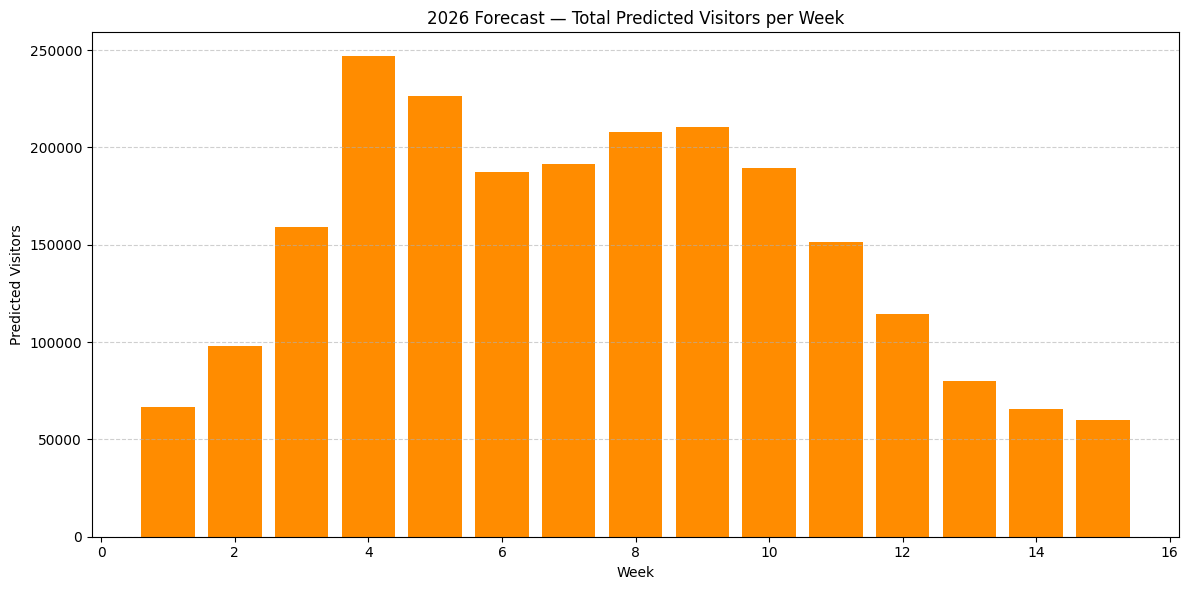

In [ ]:
# === Weekly Predictions (2026) ===
weekly_2026 = (
    pred_2026.groupby("Week", as_index=False)["Pred_VisitorDays"]
             .sum()
             .rename(columns={"Pred_VisitorDays":"Total_Predicted_Visitors"})
             .sort_values("Week")
)

print("\n=== Weekly Predicted Visitors (2026 Forecast) ===")
print(weekly_2026.to_string(index=False))

# Optional: bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.bar(weekly_2026["Week"], weekly_2026["Total_Predicted_Visitors"], color="darkorange")
plt.title("2026 Forecast — Total Predicted Visitors per Week")
plt.xlabel("Week")
plt.ylabel("Predicted Visitors")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


=== Top  Locations (2026 Forecast) ===
        Resort    Total_Pred
      Perisher 581282.311523
       Thredbo 452657.155273
    Mt. Buller 375475.226562
   Falls Creek 304658.531738
    Mt. Hotham 274432.515625
        Selwyn  97433.428223
   Mt. Baw Baw  82376.692383
Charlotte Pass  49956.143311
  Mt. Stirling  37171.546204


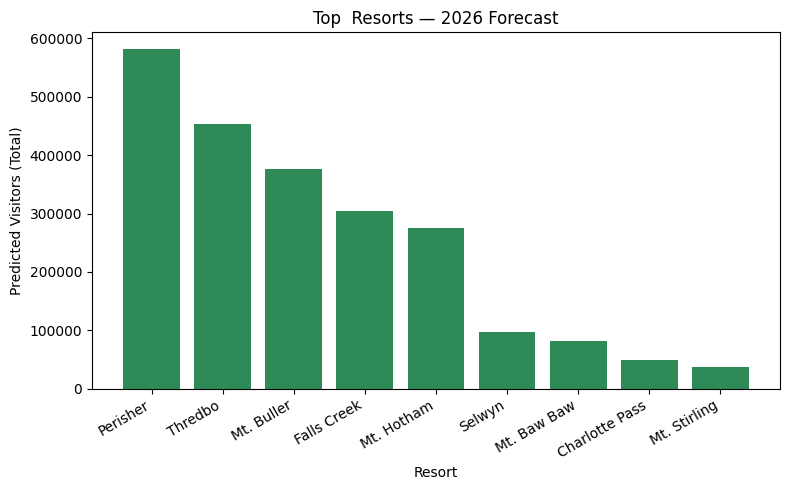

In [ ]:

top4_locations_2026 = (
    pred_2026.groupby("Resort", as_index=False)["Pred_VisitorDays"]
             .sum()
             .rename(columns={"Pred_VisitorDays":"Total_Pred"})
             .sort_values("Total_Pred", ascending=False)

)

print("\n=== Top  Locations (2026 Forecast) ===")
print(top4_locations_2026.to_string(index=False))

# Optional bar chart
plt.figure(figsize=(8,5))
plt.bar(top4_locations_2026["Resort"], top4_locations_2026["Total_Pred"], color="seagreen")
plt.title("Top  Resorts — 2026 Forecast")
plt.xlabel("Resort")
plt.ylabel("Predicted Visitors (Total)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## We can merge all data in 2024 into our prediction model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# ==========================================================
# 1. Load dataset & generate synthetic 2026
# ==========================================================
df = pd.read_csv("merged_data_3_14.csv")

# Rename for convenience
col_map = {
    "Maximum temperature (Degree C)": "tmax",
    "Minimum temperature (Degree C)": "tmin",
    "Rainfall amount (millimetres)": "rain_mm",
}
df = df.rename(columns=col_map)
for c in ["Year","Week","VisitorDays","tmax","tmin","rain_mm"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Synthetic 2026 (based on 2024 + noise)
template_2024 = df[df["Year"] == 2024].copy()
synthetic_2026 = template_2024.copy()
synthetic_2026["Year"] = 2026
rng = np.random.default_rng(42)
for col in ["tmax", "tmin", "rain_mm"]:
    noise = rng.normal(loc=0, scale=0.5, size=len(synthetic_2026))
    synthetic_2026[col] = synthetic_2026[col] + noise
synthetic_2026["VisitorDays"] = np.nan
df = pd.concat([df, synthetic_2026], ignore_index=True)

# Tidy
df = df.ffill().sort_values(["Resort","Year","Week"]).reset_index(drop=True)
df["week_sin"] = np.sin(2*np.pi*df["Week"]/52.0)
df["week_cos"] = np.cos(2*np.pi*df["Week"]/52.0)
df["ResortLabel"] = df["Resort"]
df = pd.get_dummies(df, columns=["Resort"], drop_first=False)

# ==========================================================
# 2. Train/Test split (now train until 2024)
# ==========================================================
train_mask = (df["Year"] <= 2024) & (df["Year"] != 2020)
pred_mask  = (df["Year"] == 2026)

features = ["tmax","tmin","rain_mm","week_sin","week_cos"] + \
           [c for c in df.columns if c.startswith("Resort_")]
target = "VisitorDays"

X_train = df.loc[train_mask, features].values
y_train = df.loc[train_mask, target].values
X_pred  = df.loc[pred_mask,  features].values

# ==========================================================
# 3. Scaling (fit only on TRAIN)
# ==========================================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_pred_s  = scaler_X.transform(X_pred)
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))

# ==========================================================
# 4. Sequence dataset
# ==========================================================
SEQ_LEN = 6
class SeqDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X, self.y, self.seq_len = X, y, seq_len
    def __len__(self):
        return len(self.X) - self.seq_len
    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx+self.seq_len], dtype=torch.float32),
            torch.tensor(self.y[idx+self.seq_len], dtype=torch.float32)
        )

train_ds = SeqDataset(X_train_s, y_train_s, SEQ_LEN)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)

# ==========================================================
# 5. LSTM Model
# ==========================================================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

input_dim = X_train_s.shape[1]
model = LSTMModel(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# ==========================================================
# 6. Training with Early Stopping
# ==========================================================
EPOCHS = 200
patience = 15
best_loss = float("inf")
patience_counter = 0
best_state = None

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= max(1, len(train_loader))

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        best_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ==========================================================
# 7. Roll-forward prediction (2026 only, no metrics)
# ==========================================================
def roll_forward_predict(year_mask, label):
    rows = []
    for res in sorted(df.loc[year_mask,"ResortLabel"].unique()):
        train_res = df.loc[train_mask & (df["ResortLabel"]==res)].sort_values(["Year","Week"])
        test_res  = df.loc[year_mask & (df["ResortLabel"]==res)].sort_values(["Year","Week"])
        if len(test_res)==0: continue

        seed_block = train_res[features].values[-SEQ_LEN:]
        if seed_block.shape[0] < SEQ_LEN:
            seed_block = np.vstack([np.repeat(seed_block[:1], SEQ_LEN-seed_block.shape[0], axis=0), seed_block])
        buf = scaler_X.transform(seed_block).tolist()

        for _, row in test_res.iterrows():
            x_row_s = scaler_X.transform(row[features].to_numpy().reshape(1,-1))[0]
            seq = np.vstack(buf[1:] + [x_row_s]).astype(np.float32)
            with torch.no_grad():
                pred_s = model(torch.tensor(seq).unsqueeze(0)).cpu().numpy()
            pred = scaler_y.inverse_transform(pred_s.reshape(-1,1)).flatten()[0]
            rows.append({
                "Year": int(row["Year"]),
                "Week": int(row["Week"]),
                "Resort": row["ResortLabel"],
                "Pred_VisitorDays": float(pred),
                "Source": label
            })
            buf = buf[1:] + [x_row_s]
    return pd.DataFrame(rows)

pred_2026 = roll_forward_predict(pred_mask, "Forecast2026")

# ==========================================================
# 8. Best weeks & locations (2026 Forecast)
# ==========================================================
# Top 4 locations
top4_locations = (pred_2026.groupby("Resort", as_index=False)["Pred_VisitorDays"]
                  .sum().rename(columns={"Pred_VisitorDays":"Total_Pred"})
                  .sort_values("Total_Pred", ascending=False).head(4))
print("\n=== Top 4 Locations (2026 Forecast) ===")
print(top4_locations.to_string(index=False))

# Top 4 weeks
top4_weeks = (pred_2026.groupby("Week", as_index=False)["Pred_VisitorDays"]
              .sum().rename(columns={"Pred_VisitorDays":"Total_Pred"})
              .sort_values("Total_Pred", ascending=False).head(4))
print("\n=== Top 4 Weeks (2026 Forecast, across resorts) ===")
print(top4_weeks.to_string(index=False))


Early stopping at epoch 89

=== Top 4 Locations (2026 Forecast) ===
     Resort    Total_Pred
   Perisher 615889.470703
    Thredbo 459147.396484
 Mt. Buller 396380.621582
Falls Creek 322144.605469

=== Top 4 Weeks (2026 Forecast, across resorts) ===
 Week    Total_Pred
    4 262247.763428
    5 242528.305542
    8 212846.203125
    9 210181.743530



=== Weekly Predicted Visitors (2026 Forecast, trained on 2024 data) — ALL Weeks ===
 Week Total_Predicted_Visitors
    1                   58,853
    2                   87,991
    3                  177,405
    4                  262,248
    5                  242,528
    6                  193,334
    7                  206,615
    8                  212,846
    9                  210,182
   10                  188,106
   11                  155,698
   12                  111,661
   13                   75,931
   14                   52,848
   15                   49,870

=== Resorts: Total Predicted Visitors (2026 Forecast, trained on 2024 data) — ALL Resorts ===
        Resort Total_Predicted_Visitors
      Perisher                  615,889
       Thredbo                  459,147
    Mt. Buller                  396,381
   Falls Creek                  322,145
    Mt. Hotham                  273,449
        Selwyn                   96,004
   Mt. Baw Baw                   74,687
Char

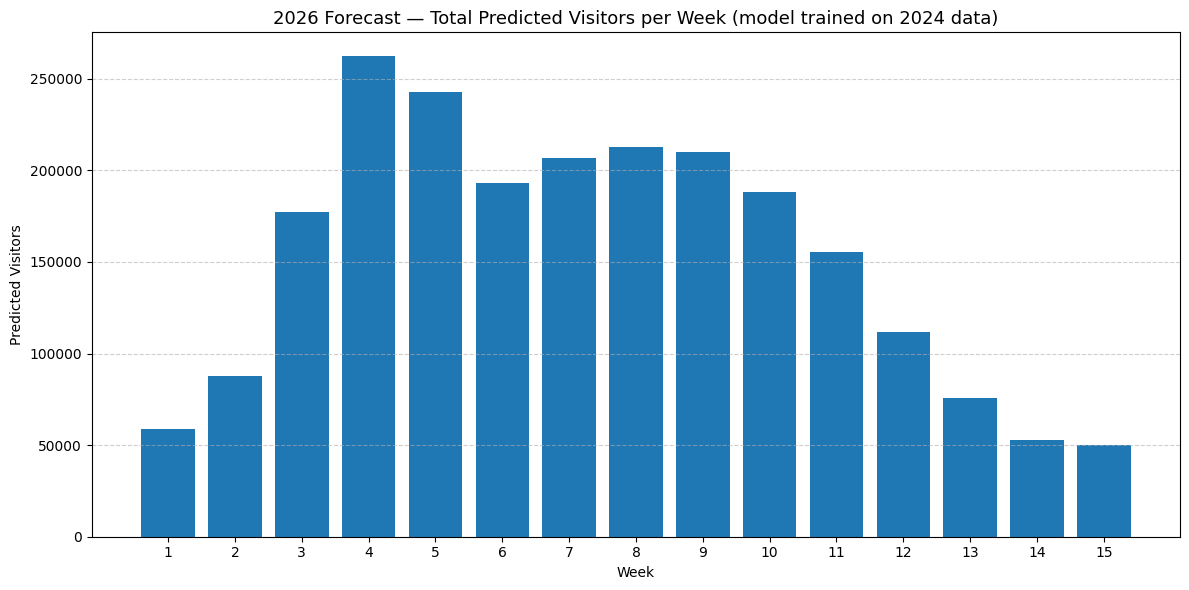

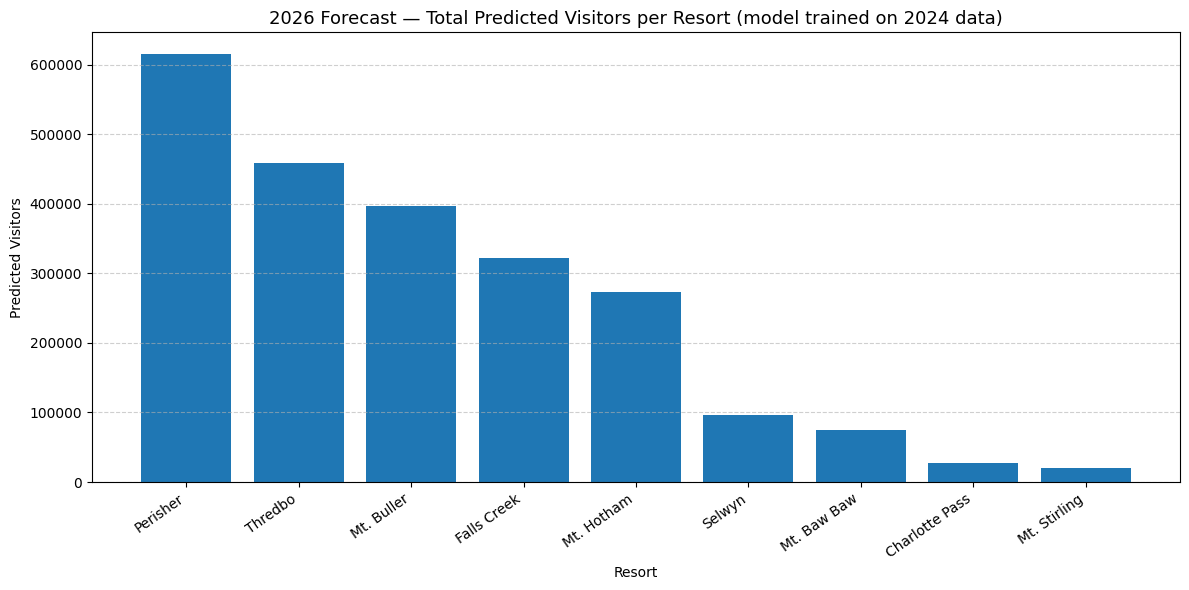

In [ ]:
# ===============================================
# Full 2026 Forecast Tables & Plots (all resorts)
# Model was trained using data through 2024 (2020 excluded)
# ===============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Safety check ---
assert 'pred_2026' in globals(), "pred_2026 not found. Run the 2026 forecast step first."

# ---- Weekly totals across all resorts (ALL weeks) ----
weekly_all = (
    pred_2026.groupby("Week", as_index=False)["Pred_VisitorDays"]
             .sum()
             .rename(columns={"Pred_VisitorDays": "Total_Predicted_Visitors"})
             .sort_values("Week")
             .reset_index(drop=True)
)

print("\n=== Weekly Predicted Visitors (2026 Forecast, trained on 2024 data) — ALL Weeks ===")
print(weekly_all.to_string(index=False, formatters={
    "Total_Predicted_Visitors": lambda x: f"{int(round(x)):,}"
}))

# ---- Resort totals across full season (ALL resorts) ----
resort_all = (
    pred_2026.groupby("Resort", as_index=False)["Pred_VisitorDays"]
             .sum()
             .rename(columns={"Pred_VisitorDays": "Total_Predicted_Visitors"})
             .sort_values("Total_Predicted_Visitors", ascending=False)
             .reset_index(drop=True)
)

print("\n=== Resorts: Total Predicted Visitors (2026 Forecast, trained on 2024 data) — ALL Resorts ===")
print(resort_all.to_string(index=False, formatters={
    "Total_Predicted_Visitors": lambda x: f"{int(round(x)):,}"
}))

# ---- Top resort per week (but showing ALL weeks) ----
top_resort_each_week = (
    pred_2026.sort_values(["Week","Pred_VisitorDays"], ascending=[True, False])
             .groupby("Week", as_index=False)
             .first()[["Week","Resort","Pred_VisitorDays"]]
             .rename(columns={"Pred_VisitorDays":"BestResort_Predicted_Visitors"})
)

print("\n=== Best Resort per Week (2026 Forecast, trained on 2024 data) — ALL Weeks ===")
print(top_resort_each_week.to_string(index=False, formatters={
    "BestResort_Predicted_Visitors": lambda x: f"{int(round(x)):,}"
}))

# =========================
# Plots (ALL weeks / resorts)
# =========================

# 1) Bar chart: ALL weeks (sum across resorts)
plt.figure(figsize=(12,6))
plt.bar(weekly_all["Week"].astype(str), weekly_all["Total_Predicted_Visitors"])
plt.title("2026 Forecast — Total Predicted Visitors per Week (model trained on 2024 data)", fontsize=13)
plt.xlabel("Week"); plt.ylabel("Predicted Visitors")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 2) Bar chart: ALL resorts (totals across season)
plt.figure(figsize=(12,6))
plt.bar(resort_all["Resort"], resort_all["Total_Predicted_Visitors"])
plt.title("2026 Forecast — Total Predicted Visitors per Resort (model trained on 2024 data)", fontsize=13)
plt.xlabel("Resort"); plt.ylabel("Predicted Visitors")
plt.xticks(rotation=35, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

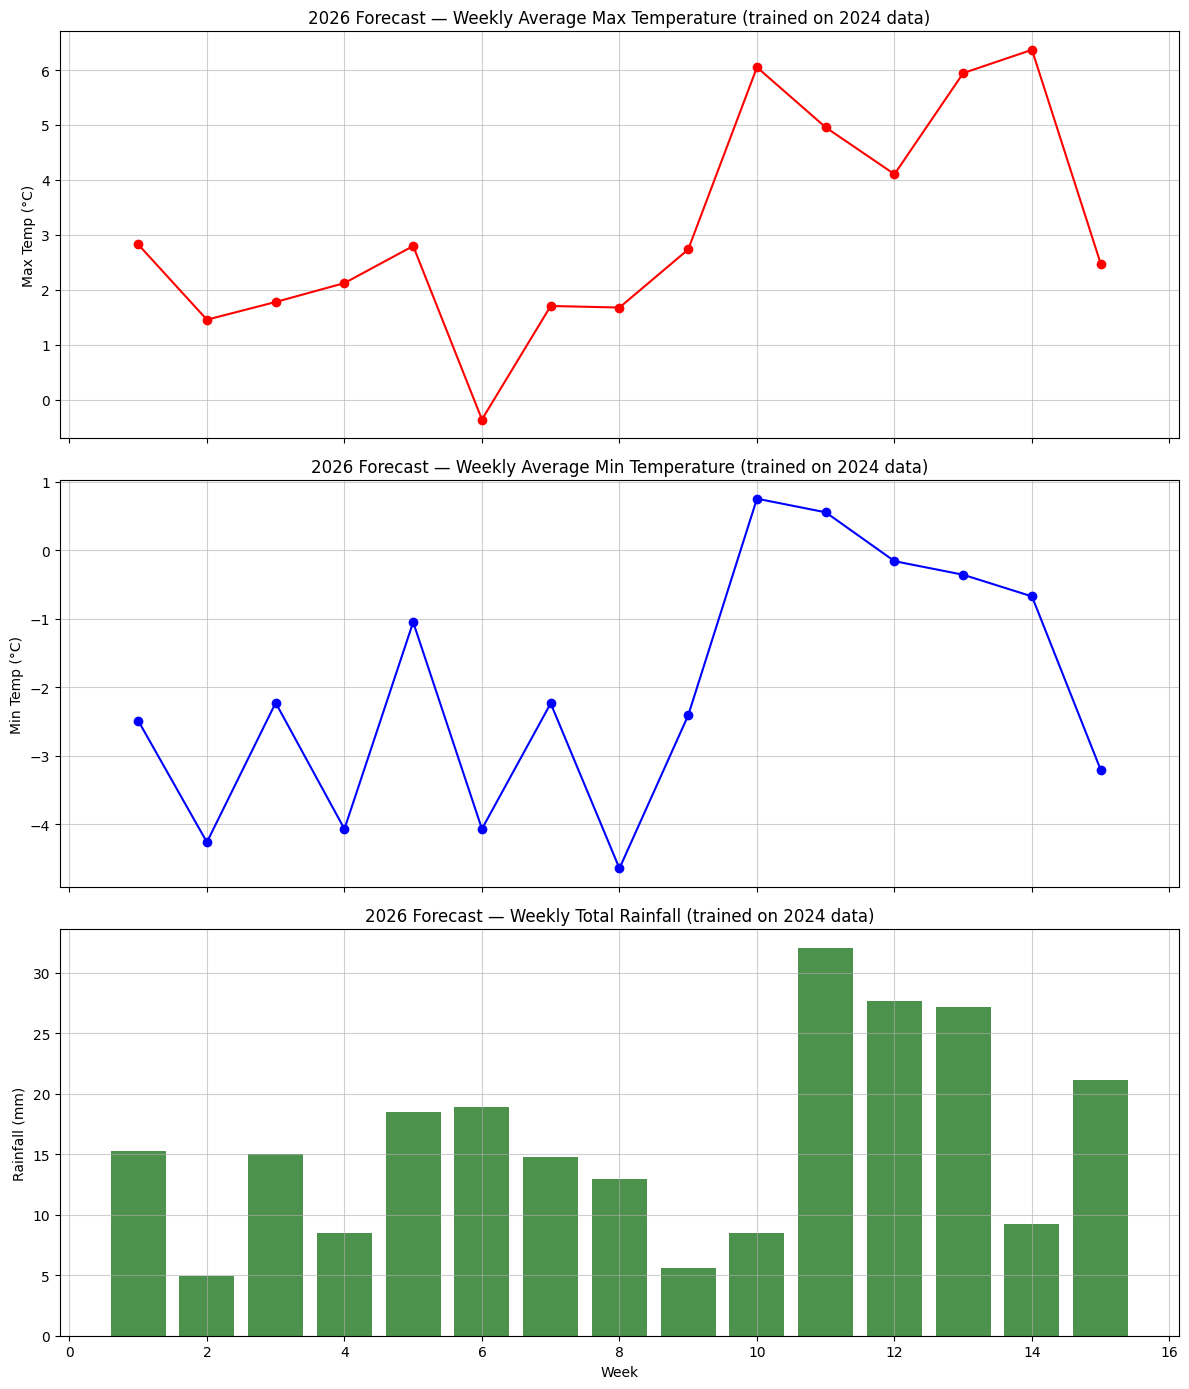

In [ ]:
# =====================================================
# Climate Forecast Distributions (Synthetic 2026)
# =====================================================

# Filter synthetic 2026 climate values
climate_2026 = df[df["Year"] == 2026][["Week","tmax","tmin","rain_mm","ResortLabel"]]

# 1) Max temperature per week (average across resorts)
weekly_tmax = climate_2026.groupby("Week")["tmax"].mean().reset_index()

# 2) Min temperature per week (average across resorts)
weekly_tmin = climate_2026.groupby("Week")["tmin"].mean().reset_index()

# 3) Rainfall per week (total across resorts)
weekly_rain = climate_2026.groupby("Week")["rain_mm"].sum().reset_index()

# ---- Plot all three side-by-side ----
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# Max temp
axes[0].plot(weekly_tmax["Week"], weekly_tmax["tmax"], marker="o", color="red")
axes[0].set_title("2026 Forecast — Weekly Average Max Temperature (trained on 2024 data)")
axes[0].set_ylabel("Max Temp (°C)")
axes[0].grid(alpha=0.6)

# Min temp
axes[1].plot(weekly_tmin["Week"], weekly_tmin["tmin"], marker="o", color="blue")
axes[1].set_title("2026 Forecast — Weekly Average Min Temperature (trained on 2024 data)")
axes[1].set_ylabel("Min Temp (°C)")
axes[1].grid(alpha=0.6)

# Rainfall
axes[2].bar(weekly_rain["Week"], weekly_rain["rain_mm"], color="darkgreen", alpha=0.7)
axes[2].set_title("2026 Forecast — Weekly Total Rainfall (trained on 2024 data)")
axes[2].set_xlabel("Week")
axes[2].set_ylabel("Rainfall (mm)")
axes[2].grid(alpha=0.6)

plt.tight_layout()
plt.show()


# **Model Summary**

- Model: Leak-free LSTM, trained on historical data (2014–2023, excluding 2020) and validated on 2024.

- Performance (2024 Test): RMSE ≈ 10.7k, R² ≈ 0.68 → model captures trends realistically.

- Seasonal Pattern: Correctly predicts early-season growth, mid-season peaks (Weeks 4–6), and late-season decline.

**2026 Forecast (using 2024 data):**

- Peak Weeks: Weeks 4–6, with predicted demand above 250k weekly visitors.

- Top Resorts: Perisher dominates overall (≈ 658k visitors), followed by Mt. Buller, Thredbo, and Falls Creek.

**Best Weekly Picks:**

- Example: Week 6, Perisher remains the strongest consistent choice.

**Insights:**

- Model is better at capturing timing/patterns than exact numbers.

- Useful for planning capacity, staffing, and marketing around peak weeks.